# TODO:
1. Try Greek dataset with wind direction and air pressure
2. Add a homoscedastic model to show comparison in likelihood and similar NRMSE

# A Deep Learning Heteroscedastic Uncertainty Approach to Fault Detection of Wind Turbines using SCADA data 

In [345]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow.keras as keras
import scipy.stats as stats
import math

from sklearn.datasets import make_friedman2
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic, ExpSineSquared
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from math import sqrt

from tensorflow.keras.layers import TimeDistributed, Attention, Input, Conv1D, MaxPooling1D, LSTM, Dense, Flatten, BatchNormalization, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#### Auxiliary Functions

In [494]:
def plot_means_variances(y_true, y_means, y_stddevs):
    min_vals = np.min([np.min(y_true), np.min(y_means)])
    max_vals = np.max([np.max(y_true), np.max(y_means)])

    plt.figure(figsize=(16, 6))

    # Plot means
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_means, alpha = .7, color="0.3", linewidth = 0, s = 2)
    plt.plot([min_vals, max_vals], [min_vals, max_vals], 'k--', color='red')  # Add diagonal line
    plt.title('Predicted vs True Values')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    
    def plot_binned_residuals(y_true, residuals, num_bins=20):
        bins = np.linspace(min(y_true), max(y_true), num_bins + 1)

        bin_means = [0]*num_bins
        bin_stddevs = [0]*num_bins

        for i in range(num_bins):
            mask = (y_true >= bins[i]) & (y_true < bins[i + 1])
            if np.any(mask):
                bin_means[i] = np.mean(y_true[mask])
                bin_stddevs[i] = np.sqrt(mean_squared_error(y_means[mask], y_true[mask]))
        return bin_means, bin_stddevs

    bin_means, bin_stddevs = plot_binned_residuals(y_true, y_means, num_bins=20)
    
    plt.subplot(1, 2, 2)
    plt.scatter(y_true, y_stddevs, alpha = .7, color="0.3", linewidth = 0, s = 2, label='Predicted Standard Deviation', zorder=1)
    plt.scatter(bin_means, bin_stddevs, alpha=1, s=50, color='red', label='True Binned Root Mean Squared Error', zorder=2)
    plt.title('Predicted Standard Deviation vs True RMSE')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Standard Deviation')
    plt.legend()


    plt.tight_layout()
    plt.show()

    
def evaluate_and_print_metrics(results, model_name, y_train, y_test, y_train_pred, y_test_pred, y_train_stddevs, y_test_stddevs, ci):
    z_value = stats.norm.ppf((1 + ci) / 2)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    train_lower_bound = y_train_pred - z_value * y_train_stddevs
    train_upper_bound = y_train_pred + z_value * y_train_stddevs

    test_lower_bound = y_test_pred - z_value * y_test_stddevs
    test_upper_bound = y_test_pred + z_value * y_test_stddevs

    train_within_interval = np.sum(np.logical_and(y_train.ravel() >= train_lower_bound, y_train.ravel() <= train_upper_bound))
    test_within_interval = np.sum(np.logical_and(y_test.ravel() >= test_lower_bound, y_test.ravel() <= test_upper_bound))

    train_percentage_within_interval = (train_within_interval / len(y_train.ravel())) * 100
    test_percentage_within_interval = (test_within_interval / len(y_test.ravel())) * 100

   
    results[model_name] = {
        "Test Root Mean Squared Error (RMSE): ": test_rmse,
        "Test Mean Absolute Error (MEA): ": test_mae,
        "Percentage of Test Data Points within {ci:.2f}% CI: ": test_percentage_within_interval
    }

    print(f"Train RMSE: {train_rmse:.3f}")
    print(f"Test RMSE: {test_rmse:.3f}")
    print(f"Train MAE: {train_mae:.3f}")
    print(f"Test MAE: {test_mae:.3f}")
    print(f"Percentage of Train Data Points within {ci*100:.2f}% CI: {train_percentage_within_interval:.2f}%")
    print(f"Percentage of Test Data Points within {ci*100:.2f}% CI: {test_percentage_within_interval:.2f}%")

In [370]:
def plot_confidence_interval_histogram(y_test_pred, y_test_std, y_test, bins=20):
    # Compute the t-values of the confidence intervals based on Z-scores
    t_values = np.array([norm.ppf(i/bins + (1-i/bins)/2) for i in range(1, bins+1)])

    percentages_within_interval = []
    for t_value in t_values:
        lower_bounds = y_test_pred.ravel() - t_value * y_test_std
        upper_bounds = y_test_pred.ravel() + t_value * y_test_std

        # Count number of data points within the confidence interval
        is_within_interval = np.logical_and(y_test >= lower_bounds, y_test <= upper_bounds)
        num_within_interval = np.sum(is_within_interval)

        # Calculate the percentage of data points within the confidence interval
        percentage_within_interval = (num_within_interval / len(y_test)) * 100
        percentages_within_interval.append(percentage_within_interval)

    plt.figure(figsize=(16, 6))
    bars = plt.bar(np.arange(1, bins+1), percentages_within_interval, color='lightgray', edgecolor='black')
    plt.xlabel('Confidence Intervals')
    plt.ylabel('Percentage within Interval')
    plt.title('Percentage of Data Points within Confidence Intervals')

    # Add numbers on top of interval bar
    for bar, percentage in zip(bars, percentages_within_interval):
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 1, f'{percentage:.2f}%', fontsize=9)

    plt.xticks(np.arange(1, bins+1), [f'{i/bins*100:.0f}%' for i in range(1, bins+1)])
    plt.show()

In [349]:
def train_model(model, X_train, y_train, patience, epochs, batch_size, cp_callback):
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    model.summary()
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_split=0.1, callbacks=[early_stopping, cp_callback])
    return history

## Data Analysis

In [350]:
keras.utils.set_random_seed(812)

In [351]:
file_path = 'Cleaned_data.pkl'
df_full = pd.read_pickle(file_path)

In [352]:
# Datetime column
DATETIME_COL = 'Date.time'

# Features considered
features = [
'Wind.speed.me',
'Wind.speed.sd',
'Wind.speed.min',
'Wind.speed.max',
'Front.bearing.temp.me',
'Front.bearing.temp.sd',
'Front.bearing.temp.min',
'Front.bearing.temp.max',
'Rear.bearing.temp.me',
'Rear.bearing.temp.sd',
'Rear.bearing.temp.min',
'Rear.bearing.temp.max',
'Rotor.bearing.temp.me',
'Stator1.temp.me',
'Nacelle.ambient.temp.me',
'Nacelle.temp.me',
'Transformer.temp.me',
'Gear.oil.temp.me',
'Gear.oil.temp.me.1',
'Top.box.temp.me',
'Hub.temp.me',
'Conv.Amb.temp.me',
'Rotor.bearing.temp.me',
'Transformer.cell.temp.me',
'Motor.axis1.temp.me',
'Motor.axis2.temp.me',
'CPU.temp.me',
'Blade.ang.pitch.pos.A.me',
'Blade.ang.pitch.pos.B.me',
'Blade.ang.pitch.pos.C.me',
'Gear.oil.inlet.press.me',
'Gear.oil.pump.press.me',
'Drive.train.acceleration.me',
'Tower.Acceleration.x',
'Tower.Acceleration.y'
]

output_feature = 'Power.me'

# Only consider the turbine with ID 5
TURBINE_ID = 5
df = df_full[df_full['turbine'] == TURBINE_ID]
print(f"Total data points for turbine {TURBINE_ID} before removing NaNs: ", len(df))
df = df.dropna(subset=features + [output_feature] + [DATETIME_COL])
print(f"Total data points for turbine {TURBINE_ID} after removing NaNs: ", len(df))
df = df.reset_index(drop=False) 

191579
189381


In [353]:
df.head()

index           Date.time    Power.me   Power.sd   Power.min   Power.max  \
0  778652 2017-09-25 00:00:00  170.785782  18.711275  117.633080  201.376236   
1  778653 2017-09-25 00:10:00  196.361282  29.352943  132.657440  244.603409   
2  778654 2017-09-25 00:20:00  213.066101  18.548962  175.467987  244.880829   
3  778655 2017-09-25 00:30:00  180.647583  16.838543  143.989594  220.636795   
4  778656 2017-09-25 00:40:00  201.553589  11.615179  178.872192  223.635696   

   Pot.Power.me  Wind.speed.me  Wind.speed.sd  Wind.speed.min  Wind.speed.max  \
0    178.246281       4.758976       0.470051        3.839334        5.655419   
1    214.993427       5.053728       0.455439        4.297034        5.879260   
2    186.659122       4.834767       0.438846        3.727230        5.667759   
3    194.940699       4.909376       0.403833        3.910666        5.488893   
4    182.866606       4.800600       0.485835        4.098299        5.829768   

   Power.factor.cosphi.me  Power.factor.cosphi.sd  Power.factor.cosphi.min  \
0               -0.816310                0.026759                -0.861975   
1               -0.834383                0.039303                -0.882974   
2               -0.853823                0.019689                -0.880380   
3               -0.823434                0.023775                -0.869783   
4               -0.833498                0.013805                -0.856276   

   Power.factor.cosphi.max  Front.bearing.temp.me  Front.bearing.temp.sd  \
0                -0.747296              66.905266               0.300394   
1                -0.727314              66.657501               0.230908   
2                -0.803499              67.272499               0.084375   
3                -0.766870              67.349998               0.128452   
4                -0.811200              67.722504               0.181987   

   Front.bearing.temp.min  Front.bearing.temp.max  Rear.bearing.temp.me  \
0               66.500000               67.350006             65.931580   
1               66.300003               67.099998             65.932503   
2               67.099998               67.400002             66.452499   
3               67.050003               67.550003             66.452499   
4               67.400002               68.050003             66.864998   

   Rear.bearing.temp.sd  Rear.bearing.temp.min  Rear.bearing.temp.max  \
0              0.185111              65.699997              66.300003   
1              0.214055              65.649994              66.400002   
2              0.081354              66.350006              66.599998   
3              0.094172              66.300003              66.699997   
4              0.150084              66.500000              67.099998   

   Stator1.temp.me  Stator1.temp.sd  Stator1.temp.min  Stator1.temp.max  \
0        62.171051              NaN               NaN               NaN   
1        63.545002              NaN               NaN               NaN   
2        64.862503              NaN               NaN               NaN   
3        64.239998              NaN               NaN               NaN   
4        61.730000              NaN               NaN               NaN   

   Nacelle.ambient.temp.me  Nacelle.ambient.temp.sd  Nacelle.ambient.temp.min  \
0                14.042106                      NaN                       NaN   
1                13.960000                      NaN                       NaN   
2                13.889999                      NaN                       NaN   
3                13.797501                      NaN                       NaN   
4                13.690001                      NaN                       NaN   

   Nacelle.ambient.temp.max  Nacelle.temp.me  Nacelle.temp.sd  \
0                       NaN        24.947369              NaN   
1                       NaN        25.037500              NaN   
2                       NaN        24.997499              NaN   
3                     

In [354]:
descriptive_stats = df[features + [output_feature]].describe()
pd.set_option('display.max_columns', None)
display(descriptive_stats)

Wind.speed.me  Wind.speed.sd  Wind.speed.min  Wind.speed.max  \
count  189381.000000  189381.000000   189381.000000   189381.000000   
mean        6.061792       0.929598        4.285672        7.826800   
std         2.767883       0.461186        2.206099        3.482993   
min         0.129863       0.000000       -0.444250        0.243750   
25%         4.052706       0.595049        2.674919        5.362026   
50%         5.707567       0.851638        4.071932        7.317771   
75%         7.657582       1.180467        5.618109        9.794380   
max        22.151195       5.016237       17.995665       32.264656   

       Front.bearing.temp.me  Front.bearing.temp.sd  Front.bearing.temp.min  \
count          189381.000000          189381.000000           189381.000000   
mean               65.249559               0.611390               64.235198   
std                10.096854               0.504141                9.916454   
min                14.565001               0.000000               14.400000   
25%                61.002500               0.236114               60.099998   
50%                69.794736               0.475730               68.449997   
75%                72.277500               0.845470               71.199997   
max                81.182500               7.816919               80.800003   

       Front.bearing.temp.max  Rear.bearing.temp.me  Rear.bearing.temp.sd  \
count           189381.000000         189381.000000         189381.000000   
mean                66.234087             63.228148              0.665511   
std                 10.287366              8.592414              0.576825   
min                 14.600000             13.147500              0.000000   
25%                 61.900002             61.092499              0.240885   
50%                 70.900002             66.140001              0.477723   
75%                 73.300003             68.575001              0.928453   
max                 81.449997             75.092500              7.473754   

       Rear.bearing.temp.min  Rear.bearing.temp.max  Rotor.bearing.temp.me  \
count          189381.000000          189381.000000          189381.000000   
mean               62.131779              64.294001              25.147016   
std                 8.409253               8.819052               3.963058   
min                13.100000              13.200000               9.002500   
25%                60.400002              61.849998              22.215000   
50%                65.050003              67.000000              25.049999   
75%                67.199997              70.000000              28.059524   
max                74.649994              76.400002              39.097499   

       Stator1.temp.me  Nacelle.ambient.temp.me  Nacelle.temp.me  \
count    189381.000000            189381.000000    189381.000000   
mean         62.680004                10.395775        19.545742   
std           7.853748                 5.895684         5.386682   
min          13.720000                -6.800000         1.245000   
25%          59.665001                 6.020000        15.917500   
50%          62.027500                 9.690000        19.530000   
75%          64.492499                14.352500        23.075000   
max         103.014999                35.225000        39.430000   

       Transformer.temp.me  Gear.oil.temp.me  Gear.oil.temp.me.1  \
count        189381.000000     189381.000000       189381.000000   
mean             48.827492         48.283892           52.035799   
std              19.850288          8.085823            5.862262   
min              18.690001          9.235000           13.857500   
25%              35.562500         42.110000           49.326313   
50%              42.087499         50.200000           53.122500   
75%              54.002631         55.132500           56.322498   
max             107.987503         60.208335           59.926316   

       Top.box.temp.me    Hub.te

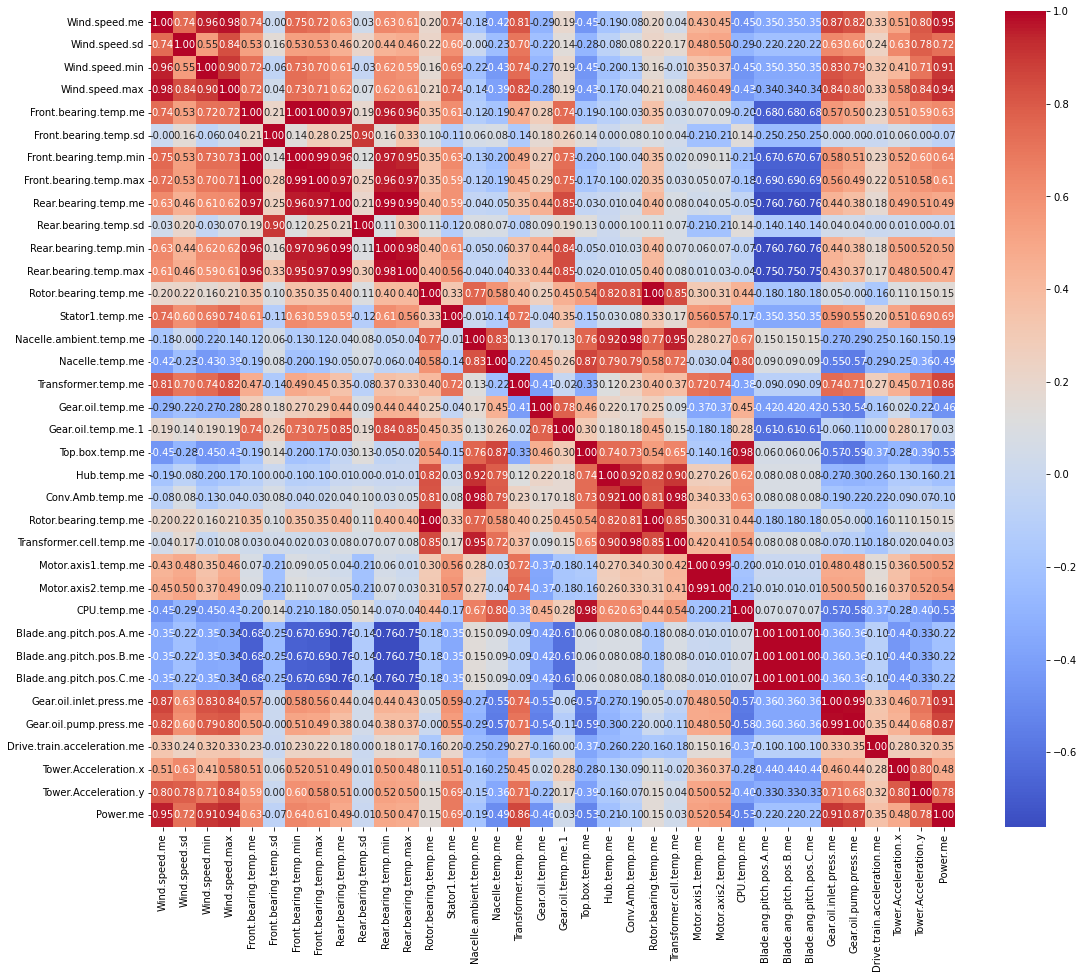

In [355]:
plt.figure(figsize=(18, 15))
correlation_matrix = df[features + [output_feature]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

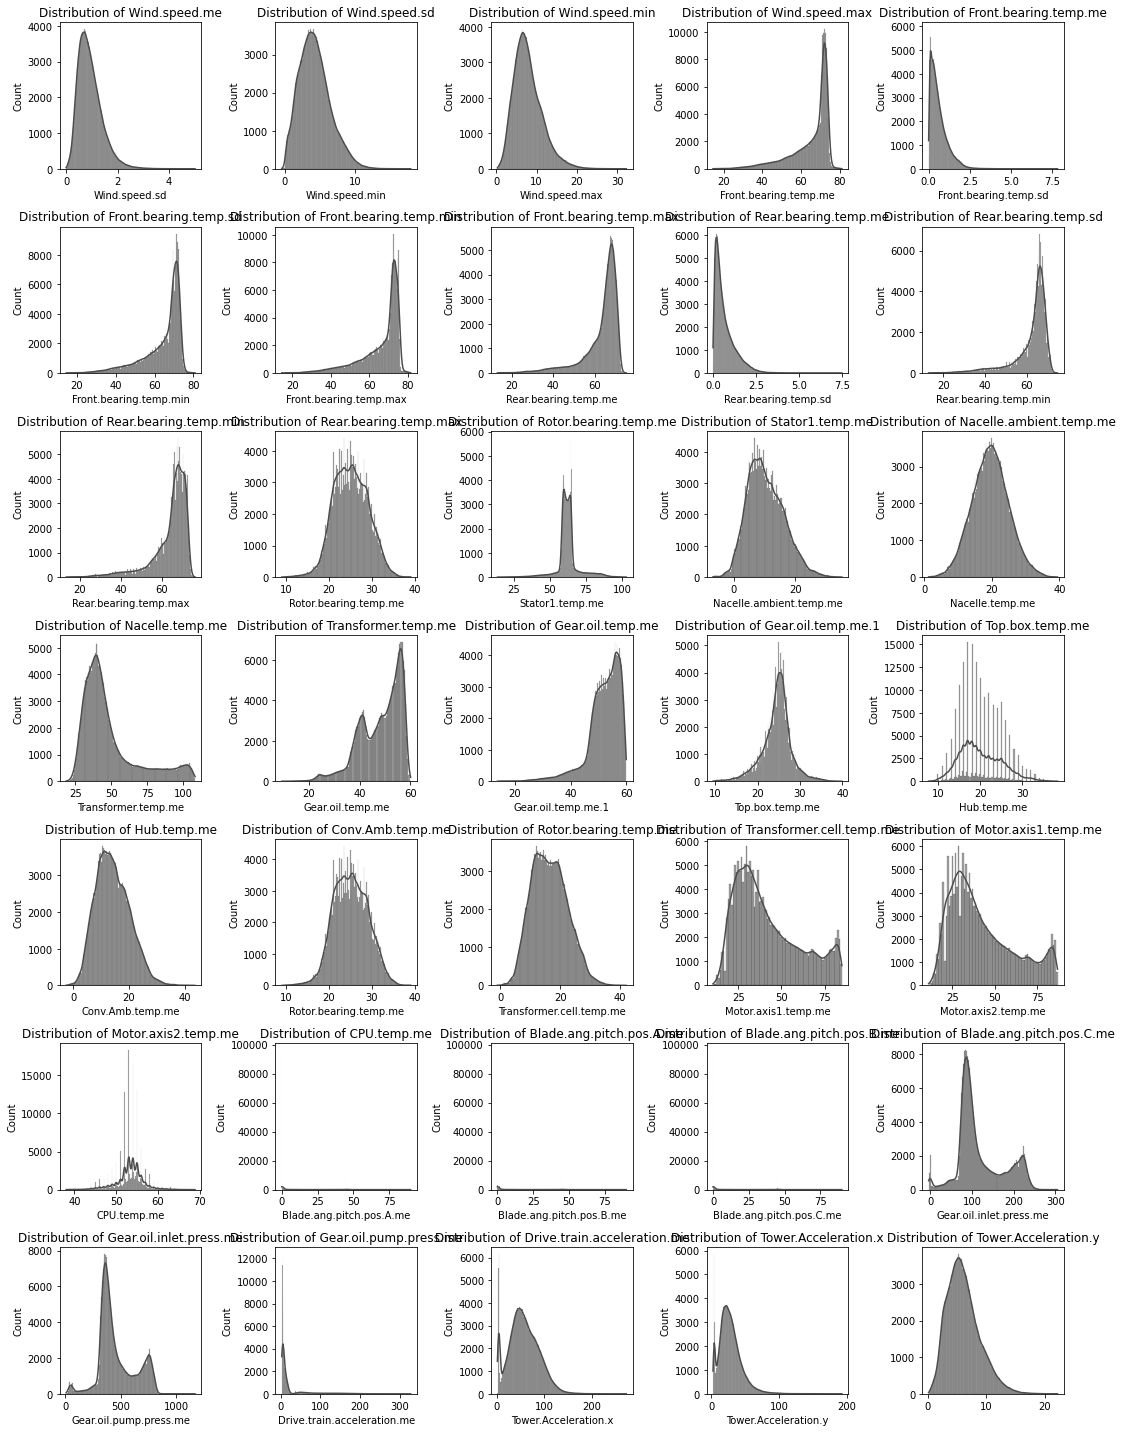

In [356]:
num_cols = 5
num_rows = math.ceil(len(features) // num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))

axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(df[feature], kde=True, ax=axes[i-1], color="0.3")
    axes[i].set_title(f'Distr. of {feature}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')


plt.tight_layout()
plt.show()

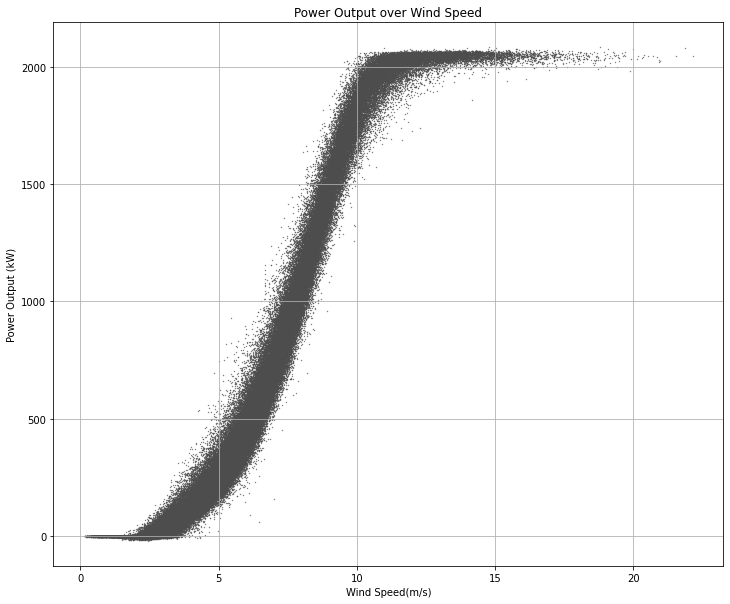

In [357]:
# Plot Power over Wind Speed
plt.figure(figsize=(12, 10))
plt.scatter(df['Wind.speed.me'], df[output_feature], alpha = .7, color="0.3", linewidth = 0, s = 2)
plt.title('Power Output over Wind Speed')
plt.xlabel('Wind Speed(m/s)')
plt.ylabel('Power Output (kW)')
plt.grid(True)
plt.show()

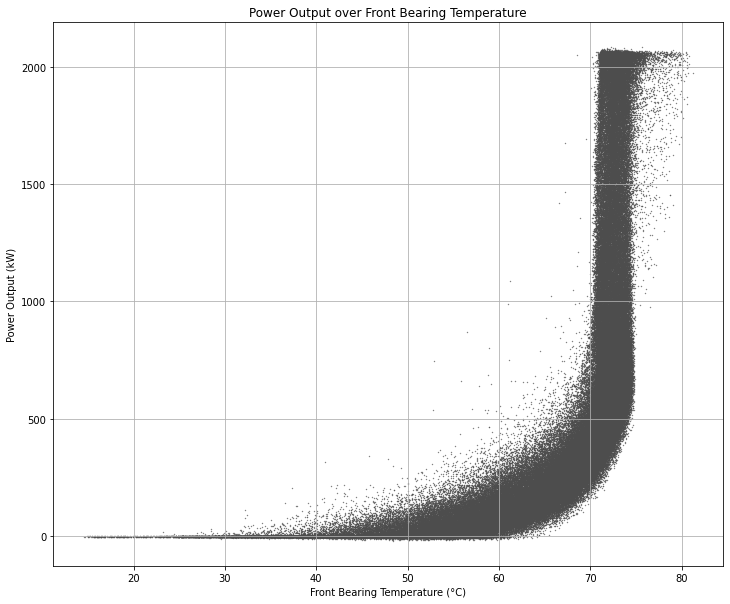

In [358]:
# Plot Power over Front Bearing Temperature
plt.figure(figsize=(12, 10))
plt.scatter(df['Front.bearing.temp.me'], df[output_feature], alpha = .7, color="0.3", linewidth = 0, s = 2)
plt.title('Power Output over Front Bearing Temperature')
plt.xlabel('Front Bearing Temperature (°C)')
plt.ylabel('Power Output (kW)')
plt.grid(True)
plt.show()

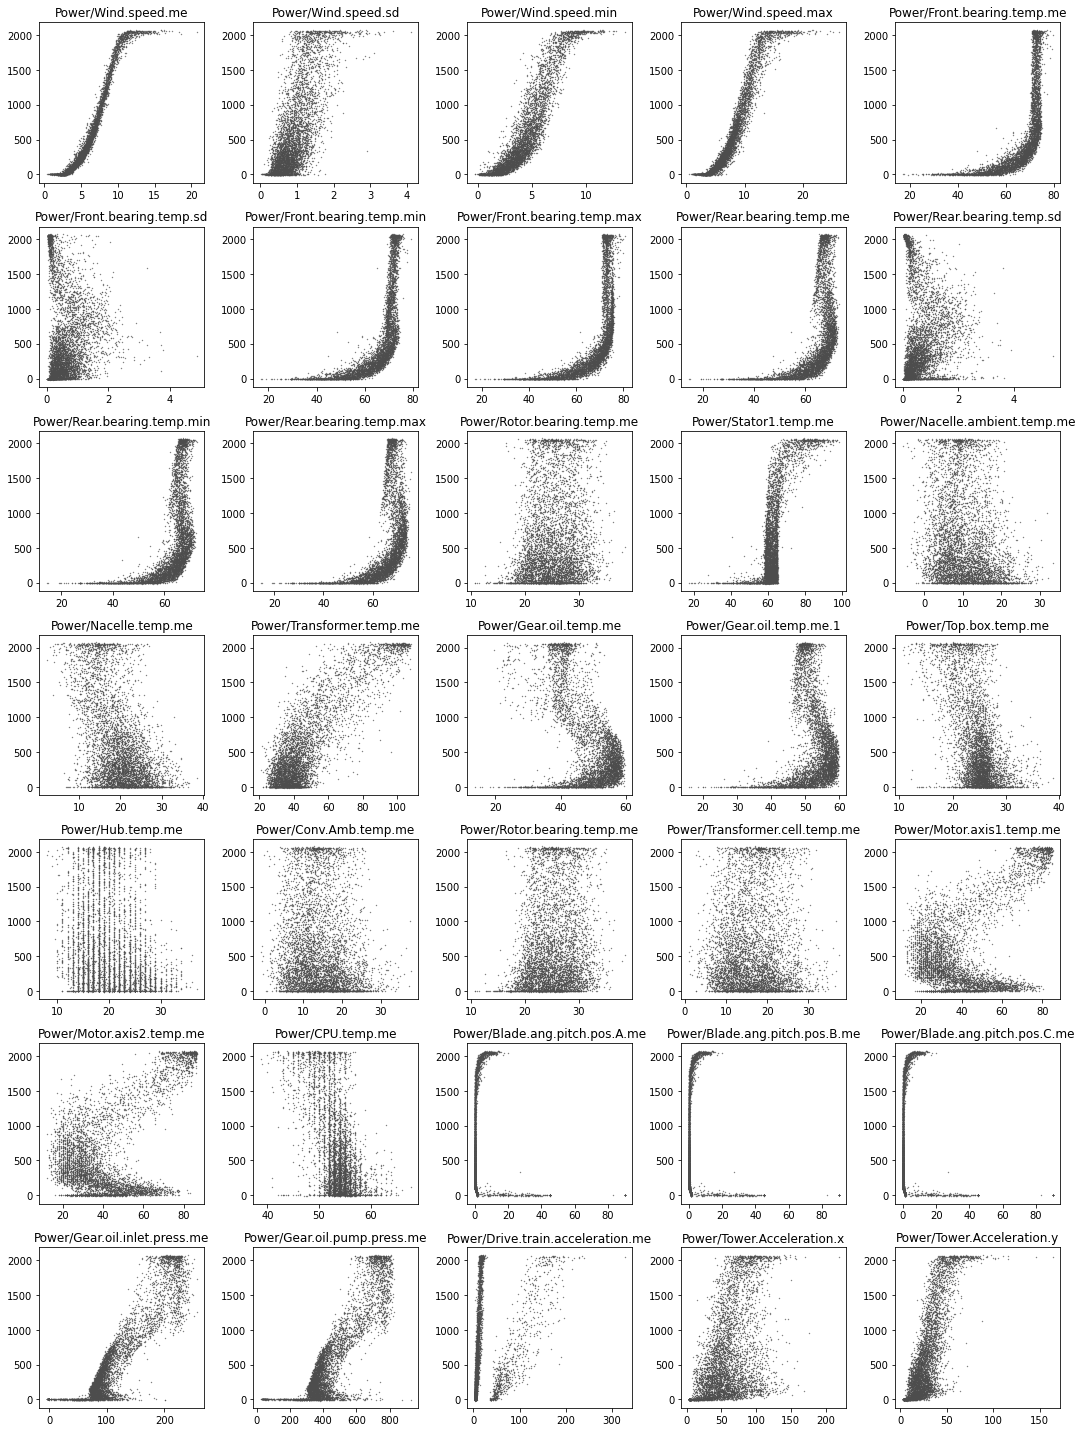

In [470]:
def plot_power_over_all_features(df, features, output_feature, sample_size=5000):
    df_sampled = df.sample(min(sample_size, len(df)))
    
    num_cols = 5
    num_rows = math.ceil(len(features) // num_cols)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))
    axes = axes.flatten()
    
    for i, feature in enumerate(features):
        axes[i].scatter(x=df_sampled[feature], y=df_sampled[output_feature], alpha=0.7, color="0.3", linewidth=0, s=2)
        axes[i].set_title(f'Power/{feature}')
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')

    plt.tight_layout()
    plt.show()
    
plot_power_over_all_features(df, features, output_feature, sample_size=5000)

These plots show, first of all, the non-linearity relationship between power output and operatioanl variables, and secondly, how the variance can significantly vary within features domains

In [502]:
def load_dataset_train_test_split(df, features, output_feature):
    X = df[features]
    y = df[output_feature]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

    # Scale input data to facilitate training
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, np.array(y_train), np.array(y_test), scaler

In [360]:
X_train, X_test, y_train, y_test, scaler = load_dataset_train_test_split(df, features, output_feature)

In [361]:
X_train.shape

(151504, 35)

In [362]:
# Set confidence interval to be considered as 'normal behaviour'
CONFIDENCE_INTERVAL = 0.99

In [477]:
def NLL(y, distr): 
    return -distr.log_prob(y) 

# We add 0.001 to the standard deviation to ensure it does not converge to 0 and destabilizes training because the gradient
# of maximum likelihood estimation requires the inversion of the variance. We also activate the parameters using a softplus
# activation function to enfore a positive standard deviation estimate.
def normal_softplus(params): 
    return tfd.Normal(loc=params[:, 0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:, 1:2]))

def multivariate_covariance_normal_softplus(mean_params, std_params, d): 
    means = mean_params
    stds = 1e-3 + tf.math.softplus(0.05 * std_params)
    
    return tfd.MultivariateNormalTriL(loc=means, scale_tril=tfp.math.fill_triangular(stds))

def multivariate_diagonal_normal_softplus(mean_params, std_params, d): 
    means = mean_params
    stds = 1e-3 + tf.math.softplus(0.05 * std_params)
    
    return tfd.MultivariateNormalDiag(loc=means, scale_diag=stds)

In [364]:
results = {}

## Standard (Homoscedastic) Neural Networks

We develop a deterministic multilayer perceptron (MLP) that uses as a loss function the mean squared error (MSE). The use of MSE as the loss function requires the assumption that the noise is identically and independently distributed accross the domain. The 'identically distributed' assumtpion assumes that the variance of the noise is not a function of the input parameters. Because of this, the deterministic MLP proposed below only accounts for homoscedastic sources of aleatoric and epistemic. However, the amount of error expressed by the model cannot be explicitly divided into epistemic and aleatoric uncertainty as the model does not explicitly output a distribution but a prediction. Confidence intervals can be derived as a function by assuming a gaussian distribution centred in the output of the network and with variance approximated by the MSE.

In [32]:
def create_model_mlp_non_probabilistic(X_train):
    inputs = Input(shape=(X_train.shape[1],))
    hidden = Dense(80, activation="relu")(inputs)
    hidden = Dense(50, activation="relu")(hidden)
    hidden = Dense(20, activation="relu")(hidden)
    output = Dense(1, activation="linear")(hidden) 

    model_mlp_non_probabilistic = Model(inputs=inputs, outputs=output)
    model_mlp_non_probabilistic.compile(Adam(learning_rate=0.001), loss='mean_squared_error')
    
    return model_mlp_non_probabilistic

model_mlp_non_probabilistic = create_model_mlp_non_probabilistic(X_train)

In [34]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_mlp_non_probabilistic_bnn_flipout_sample.keras",
                                                 save_weights_only=True,
                                                 verbose=0)

history = train_model(model_mlp_non_probabilistic,
                      X_train, y_train,
                      patience=10, epochs=100, batch_size=32,
                      cp_callback=cp_callback)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 35)]              0         
                                                                 
 dense_4 (Dense)             (None, 80)                2880      
                                                                 
 dense_5 (Dense)             (None, 50)                4050      
                                                                 
 dense_6 (Dense)             (None, 20)                1020      
                                                                 
 dense_7 (Dense)             (None, 1)                 21        
                                                                 
Total params: 7971 (31.14 KB)
Trainable params: 7971 (31.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
4262/4262 [==

In [35]:
model_mlp_non_probabilistic.load_weights("saved_models/model_mlp_non_probabilistic.keras")

In [36]:
model_mlp_non_probabilistic.evaluate(X_test, y_test)

1184/1184 [==============================] - 2s 1ms/step - loss: 795.8568


795.8567504882812

In [365]:
model_mlp_non_probabilistic = load_model("saved_models/model_mlp_non_probabilistic.keras")

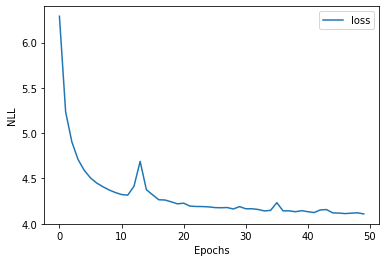

In [366]:
plt.plot(history.history['loss'][1:])
plt.legend(['loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show()

In [367]:
y_train_pred = np.array(model_mlp_non_probabilistic.predict(X_train)).ravel()
y_test_pred = np.array(model_mlp_non_probabilistic.predict(X_test)).ravel()

# We approximate the standard deviation of the assumed gaussian noise by using the RMSE of the prediction. This also assumes
# homoscedasticity nature of the noise.
y_train_stddevs = np.full(len(y_train_pred), np.sqrt(mean_squared_error(y_train, y_train_pred)))
y_test_stddevs = np.full(len(y_test_pred), np.sqrt(mean_squared_error(y_test, y_test_pred)))

evaluate_and_print_metrics(results, "Non-probabilistic MLP",
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

1184/1184 [==============================] - 3s 2ms/step
Train RMSE: 28.023
Test RMSE: 28.211
Train MAE: 16.698
Test MAE: 16.824
Percentage of Train Data Points within 99.00% CI: 96.28%
Percentage of Test Data Points within 99.00% CI: 96.24%


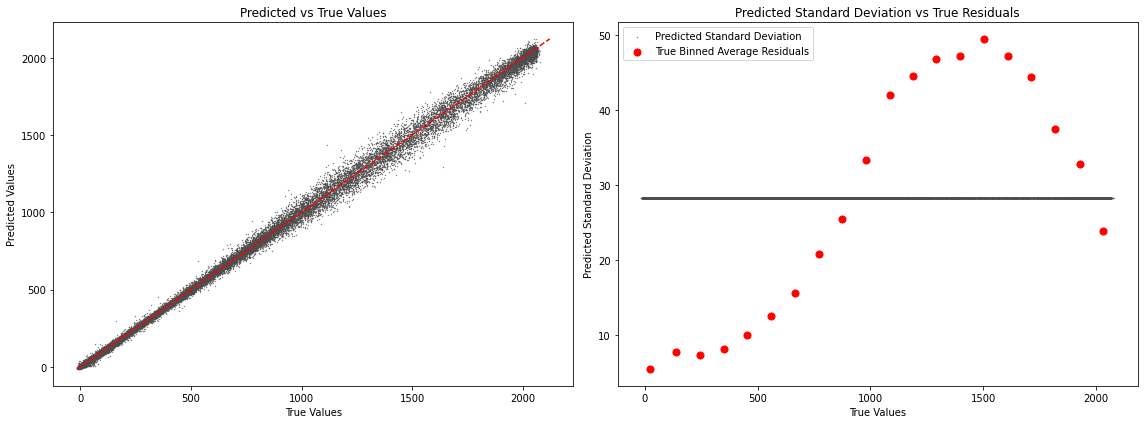

In [375]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

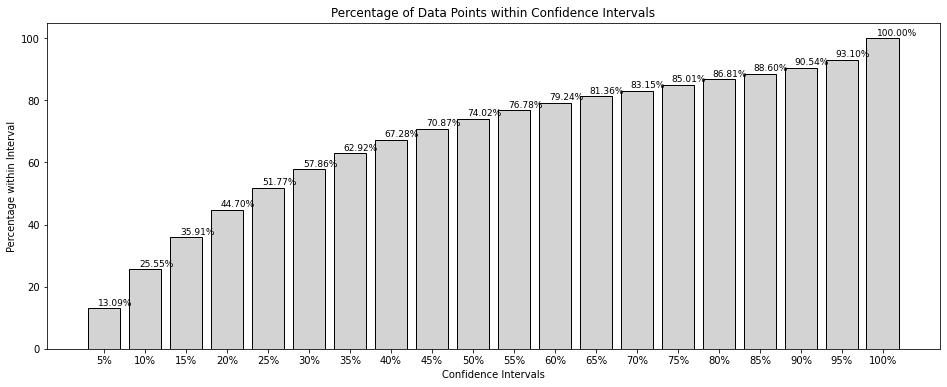

In [376]:
plot_confidence_interval_histogram(y_test_pred, y_test_stddevs, y_test, bins=20)

As you can see, althought the standard non-probabilistic neural network is an excellent approximator of the non linear relationship between SCADA variables and power output, as shown by the low RMSE, it is not a good model for evaluating uncertainty in prediction. It poorly overestimates uncertainty for power outputs, underestimates noise for mid-high power outputs, and again overestimates noise for the power outputs approaching 2000kW.

## Bayesian Neural Networks (Deterministic Output)

The purpose of introducing Bayesian Inference in neural networks is to introduce an estimation of the epistemic uncertainty (i.e., the uncertainty of the model - reducible with further training) of the model. In this framework, the model's weights are represented as posterior distributions instead of point-estimates. Therefore, as compared to traditional neural networks, the purpose of Bayesian Neural Network is to infere weight distributions from which an output given an input can be sampled. This represents the uncertainty of the model due to lack of data coverage. Typically, we expect epistemic uncertainty to be quite low for SCADA data sets as they provide large availability of data. 

BNN models are typically employed in data scarse systems, where identifying the uncertainty due to the lack of sufficient training is paramount. Because our dataset contains over 150,000 data entries, we expect low levels of epistemic uncertainty. This because it is possible to reduce epistemic uncertainty by giving the model sufficient representability capacity and train it over a sufficiently large dataset with respect to the number of model parameters. Nevertheless, we explore the use of BNN with deterministic output and probabilistic weights as a baseline model, and to show that most of the uncertainty in our regression task is given by irreducible noise and confirm that this is input-dependent. The models presented below leverage the approximate Bayesian Inference approach using Dense Flipout hidden layers. However, they have a non-probabilistic output, meaning it is unable to express heteroscedastic sources of aleatoric uncertainty. Again, because it minimizes the MSE, it assumes the data is distributed around an unknown function we are trying to approximate with an additive noise with homoscedastic variance.  

In particular, because of the higher computational complexity associated with BNNs as compared to standard neural networks, we have to reduce the size of our dataset to a 1% random sample.

In [377]:
SAMPLE_PERCENTAGE = 0.01

sampled_indices = np.random.choice(len(X_train), int(len(X_train) * SAMPLE_PERCENTAGE), replace=False)
X_train_sampled = X_train[sampled_indices]
y_train_sampled = y_train[sampled_indices]

In [378]:
def compute_predictions(model, X_train, X_test, num_samples=100):
    y_train_pred = []
    y_test_pred = []
    for _ in range(num_samples):
        y_train_pred.append(model.predict(X_train))
        y_test_pred.append(model.predict(X_test))
        
    y_train_pred = np.concatenate(y_train_pred, axis=1)
    y_test_pred = np.concatenate(y_test_pred, axis=1)

    y_train_pred_mean = np.mean(y_train_pred, axis=1)
    y_train_pred_stddevs = np.std(y_train_pred, axis=1)
    
    y_test_pred_mean = np.mean(y_test_pred, axis=1)
    y_test_pred_stddevs = np.std(y_test_pred, axis=1)
    
    return y_train_pred_mean, y_train_pred_stddevs, y_test_pred_mean, y_test_pred_stddevs

### Dense Flipout Layers (sample data set)

Below it is presented a Bayesian multilayer perceptron (MLP) which approximates bayesian inference using Variational Inference via Flipout [1]. We specify Normal distributions with trainable parameters as weights for all hidden layers. In this case, we have an heteroscedastic epistemic and homoscedastic aleatoric model. The heteroscedasticity nature of the represented model uncertainty is derived through the use of probability distributions as weights, while the noise is still modelled with fixed variance (aleatoric homoscedasticity) because the network has a deterministic output that minimizes the MSE (this is equivalent to Maximum A Posteriori estimation of a symmetric distribution).


[1] Wen, Y., Vicol, P., Ba, J., Tran, D., & Grosse, R. (2018). Flipout: Efficient Pseudo-Independent weight perturbations on Mini-Batches. arXiv (Cornell University). https://doi.org/10.48550/arxiv.1803.04386

In [45]:
def create_model_mlp_non_probabilistic_bnn_flipout(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1):
    
    kl_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X_train.shape[0] * 1.0)
    
    inputs = Input(shape=(X_train.shape[1],))
    
    hidden1 = tfp.layers.DenseFlipout(
            units=30,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            kernel_divergence_fn = kl_divergence_fn,
            activation = "relu"
        )(inputs)
    
    hidden2 = tfp.layers.DenseFlipout(
            units=30,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            kernel_divergence_fn = kl_divergence_fn,
            activation = "relu"
        )(hidden1)
    
    hidden3 = tfp.layers.DenseFlipout(
            units=20,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            kernel_divergence_fn = kl_divergence_fn,
            activation = "relu"
        )(hidden2)
    
    output = Dense(1, activation="linear")(hidden3) 

    model_mlp_non_probabilistic_bnn = Model(inputs=inputs, outputs=output)
    model_mlp_non_probabilistic_bnn.compile(RMSprop(learning_rate=0.001), loss='mean_squared_error')

    return model_mlp_non_probabilistic_bnn

model_mlp_non_probabilistic_bnn_flipout_sample = create_model_mlp_non_probabilistic_bnn_flipout(X_train_sampled, y_train_sampled)

C:\Users\filip\anaconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
C:\Users\filip\anaconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [46]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_mlp_non_probabilistic_bnn_flipout_sample.keras",
                                                 save_weights_only=True,
                                                 verbose=0)

history = train_model(model_mlp_non_probabilistic_bnn_flipout_sample,
                      X_train_sampled, y_train_sampled,
                      patience=10, epochs=100, batch_size=256,
                      cp_callback=cp_callback)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 35)]              0         
                                                                 
 dense_flipout (DenseFlipou  (None, 30)                4230      
 t)                                                              
                                                                 
 dense_flipout_1 (DenseFlip  (None, 30)                3630      
 out)                                                            
                                                                 
 dense_flipout_2 (DenseFlip  (None, 20)                2420      
 out)                                                            
                                                                 
 dense_8 (Dense)             (None, 1)                 21        
                                                           

In [379]:
# Load the model weights
model_mlp_non_probabilistic_bnn_flipout_sample.load_weights("saved_models/model_mlp_non_probabilistic_bnn_flipout_sample.keras")

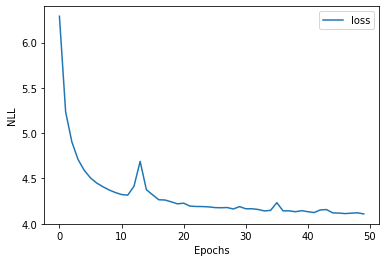

In [380]:
plt.plot(history.history['loss'][1:])
plt.legend(['loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show()

In [381]:
y_train_pred_mean, y_train_pred_stddevs, \
y_test_pred_mean, y_test_pred_stddevs = \
compute_predictions(model_mlp_non_probabilistic_bnn_flipout_sample, X_train, X_test, num_samples=20)

1184/1184 [==============================] - 4s 3ms/step


In [382]:
y_train_pred = y_train_pred_mean.ravel()
y_test_pred = y_test_pred_mean.ravel()

y_train_stddevs = y_train_pred_stddevs.ravel()
y_test_stddevs = y_test_pred_stddevs.ravel()

evaluate_and_print_metrics(results, f"Epistemic Uncertainty BNN (Flipout) - {SAMPLE_PERCENTAGE*100}% Sample", y_train, y_test, y_train_pred, y_test_pred, y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

Train RMSE: 69.866
Test RMSE: 69.548
Train MAE: 46.316
Test MAE: 46.035
Percentage of Train Data Points within 99.00% CI: 43.48%
Percentage of Test Data Points within 99.00% CI: 43.93%


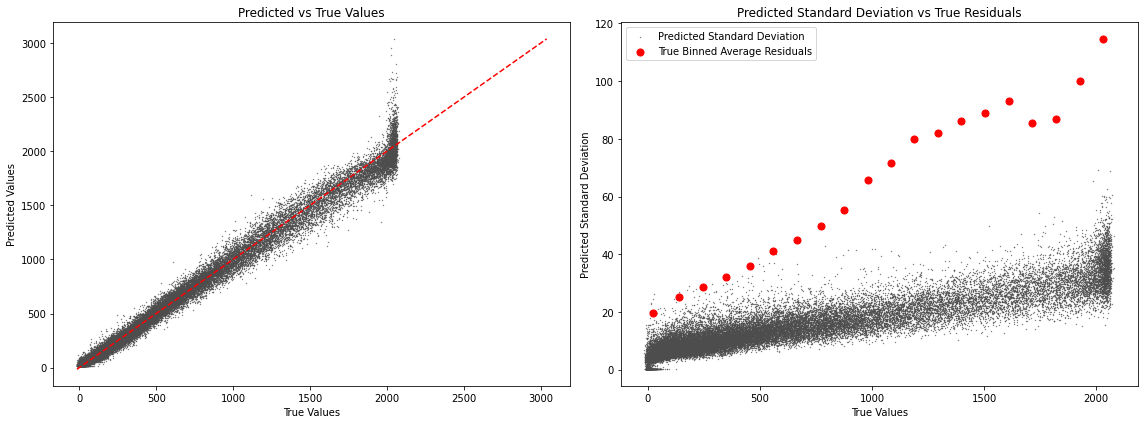

In [383]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

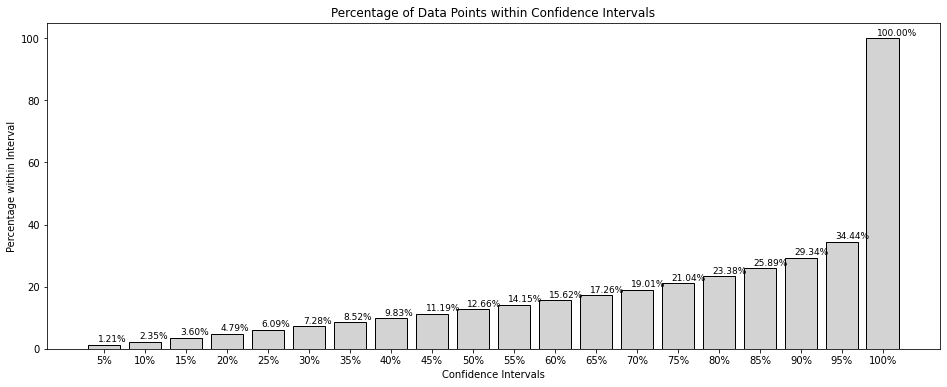

In [384]:
plot_confidence_interval_histogram(y_test_pred, y_test_stddevs, y_test, bins=20)

The RMSE of the of the model is high. We explore if this can be reduced with further training by considering the full training data set.

### Dense Flipout Layers (full data set)

An equivalent model as shown above, but trained over the full dataset. We show how further training can reduce epistemic uncertainty and decrease the prediction error of the model. However, we show how this is not fully representative of the uncertainty in the system, since most of the uncertainty is given by the variance of the noise, which we cannot model with a deterministic output.

In [53]:
model_mlp_non_probabilistic_bnn_flipout = create_model_mlp_non_probabilistic_bnn_flipout(X_train, y_train)

C:\Users\filip\anaconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
C:\Users\filip\anaconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_mlp_non_probabilistic_bnn_flipout.keras",
                                                 save_weights_only=True,
                                                 verbose=0)

history = train_model(model_mlp_non_probabilistic_bnn_flipout,
                      X_train, y_train,
                      patience=20, epochs=400, batch_size=256,
                      cp_callback=cp_callback)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 35)]              0         
                                                                 
 dense_flipout_3 (DenseFlip  (None, 30)                4230      
 out)                                                            
                                                                 
 dense_flipout_4 (DenseFlip  (None, 30)                3630      
 out)                                                            
                                                                 
 dense_flipout_5 (DenseFlip  (None, 20)                2420      
 out)                                                            
                                                                 
 dense_9 (Dense)             (None, 1)                 21        
                                                           

4262/4262 [==============================] - 10s 2ms/step - loss: 799.4100 - val_loss: 1447.0022
Epoch 138/400
4262/4262 [==============================] - 11s 3ms/step - loss: 800.5197 - val_loss: 789.7689
Epoch 139/400
4262/4262 [==============================] - 11s 3ms/step - loss: 797.6197 - val_loss: 808.2548
Epoch 140/400
4262/4262 [==============================] - 10s 2ms/step - loss: 796.1141 - val_loss: 894.4962
Epoch 141/400
4262/4262 [==============================] - 10s 2ms/step - loss: 797.7647 - val_loss: 1565.7311
Epoch 142/400
4262/4262 [==============================] - 11s 3ms/step - loss: 797.0396 - val_loss: 1019.7851
Epoch 143/400
4262/4262 [==============================] - 10s 2ms/step - loss: 795.3824 - val_loss: 822.2062
Epoch 144/400
4262/4262 [==============================] - 11s 3ms/step - loss: 793.9872 - val_loss: 886.3782
Epoch 145/400
4262/4262 [==============================] - 11s 3ms/step - loss: 792.5088 - val_loss: 802.3870
Epoch 146/400
4262/42

In [385]:
# Load the model weights
model_mlp_non_probabilistic_bnn_flipout_sample.load_weights("saved_models/model_mlp_non_probabilistic_bnn_flipout.keras")

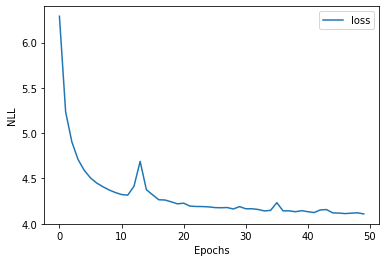

In [386]:
plt.plot(history.history['loss'][1:])
plt.legend(['loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show()

In [387]:
model_mlp_non_probabilistic_bnn_flipout.evaluate(X_test, y_test)

1184/1184 [==============================] - 5s 4ms/step - loss: 885.5031


885.5031127929688

In [388]:
y_train_pred_mean, y_train_pred_stddevs, \
y_test_pred_mean, y_test_pred_stddevs = \
compute_predictions(model_mlp_non_probabilistic_bnn_flipout, X_train, X_test, num_samples=20)

1184/1184 [==============================] - 4s 3ms/step


In [389]:
y_train_pred = y_train_pred_mean.ravel()
y_test_pred = y_test_pred_mean.ravel()

y_train_stddevs = y_train_pred_stddevs.ravel()
y_test_stddevs = y_test_pred_stddevs.ravel()

evaluate_and_print_metrics(results, "Epistemic Uncertainty BNN (Flipout)", y_train, y_test, y_train_pred, y_test_pred, y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

Train RMSE: 28.850
Test RMSE: 29.746
Train MAE: 19.552
Test MAE: 19.931
Percentage of Train Data Points within 99.00% CI: 3.94%
Percentage of Test Data Points within 99.00% CI: 3.87%


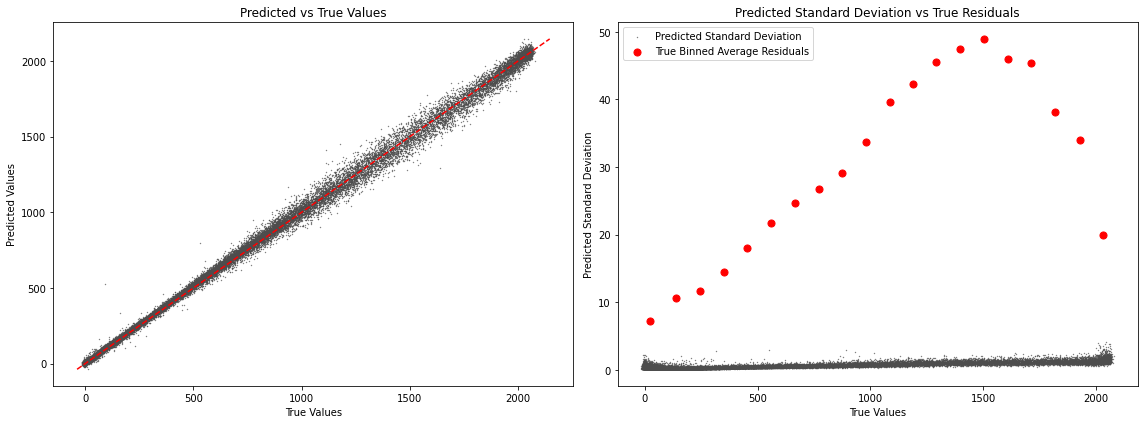

In [390]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

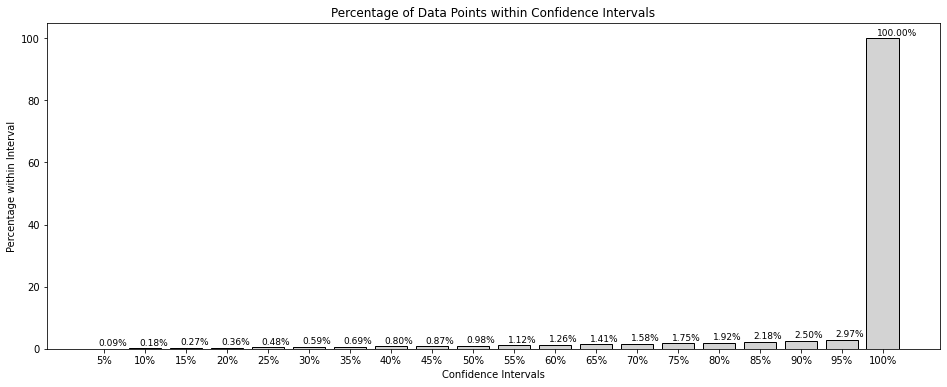

In [391]:
plot_confidence_interval_histogram(y_test_pred, y_test_stddevs, y_test, bins=20)

While the deterministic Bayesian deep model presents very low RMSE, it is a poor approximator of the overall uncertainty of the model. This because it can only express the intrinsic uncertainty of the model caused by insufficient training or lack of expressivity of the model. However, since the epistemic uncertainty is evaluated as very low, it appears that the prediction residuals of the model are mostly caused by noise, which we cannot fully model with a non-probabilistic output. Moreover, the epistemic uncertainty is estimated as independent of the output true values.

## Bayesian Neural Networks (Probabilistic Output)

We introduce a probabilistic output to a bayesian netwrok with the same number of layers as the previous but more hidden units. This way we model the output as a univariate distribution parametrized via a mean and a variance functions in the input space of the network. The loss becomes the negative log-likelihood of the identically and indipendently distributed data points. Where the distribution is a univariate Normal with a mean function and variance function paramettrized by the model.

### Dense Flipout + Gaussian Output

In [253]:
def create_model_bnn(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1):
    
    kl_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X_train.shape[0] * 1.0)
        
    inputs = Input(shape=(X_train.shape[1],))
    
    hidden1 = tfp.layers.DenseFlipout(
            units=80,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            kernel_divergence_fn = kl_divergence_fn,
            activation = "relu"
        )(inputs)
    
    hidden2 = tfp.layers.DenseFlipout(
            units=50,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            kernel_divergence_fn = kl_divergence_fn,
            activation = "relu"
        )(hidden1)
    
    hidden3 = tfp.layers.DenseFlipout(
            units=20,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            kernel_divergence_fn = kl_divergence_fn,
            activation = "relu"
        )(hidden2)
    
    # Output Univariate Normal Probabilistic Layer
    dist_params = Dense(2)(hidden3)
    dist = tfp.layers.DistributionLambda(normal_softplus)(dist_params)

    model_bnn = Model(inputs=inputs, outputs=dist)
    model_bnn.compile(Adam(learning_rate=0.001), loss=NLL)

    return model_bnn

model_bnn = create_model_bnn(X_train, y_train)

C:\Users\filip\anaconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
C:\Users\filip\anaconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [258]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_bnn.keras",
                                                 save_weights_only=True,
                                                 verbose=0)
history = train_model(model_bnn,
                      X_train, y_train,
                      patience=10, epochs=100, batch_size=256,
                      cp_callback=cp_callback)

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_50 (InputLayer)       [(None, 35)]              0         
                                                                 
 dense_flipout_9 (DenseFlip  (None, 80)                11280     
 out)                                                            
                                                                 
 dense_flipout_10 (DenseFli  (None, 50)                16050     
 pout)                                                           
                                                                 
 dense_flipout_11 (DenseFli  (None, 20)                4020      
 pout)                                                           
                                                                 
 dense_486 (Dense)           (None, 2)                 42        
                                                          

KeyboardInterrupt: 

In [65]:
model_bnn.load_weights("saved_models/model_bnn.keras")

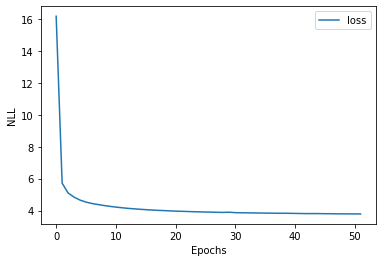

In [259]:
plt.plot(history.history['loss'][1:])
plt.legend(['loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show()

In [260]:
model_bnn.evaluate(X_test, y_test)

1184/1184 [==============================] - 3s 3ms/step - loss: 3.8199


3.8198845386505127

In [261]:
y_train_pred = np.array(model_bnn(X_train).mean()).ravel()
y_test_pred = np.array(model_bnn(X_test).mean()).ravel()

y_train_stddevs = np.array(model_bnn(X_train).stddev()).ravel()
y_test_stddevs = np.array(model_bnn(X_test).stddev()).ravel()

evaluate_and_print_metrics(results, "Aleatoric & Epistemic Uncertainty BNN (Flipout)",
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

Train RMSE: 27.768
Test RMSE: 28.406
Train MAE: 15.155
Test MAE: 15.465
Percentage of Train Data Points within 99.00% CI: 98.62%
Percentage of Test Data Points within 99.00% CI: 98.31%


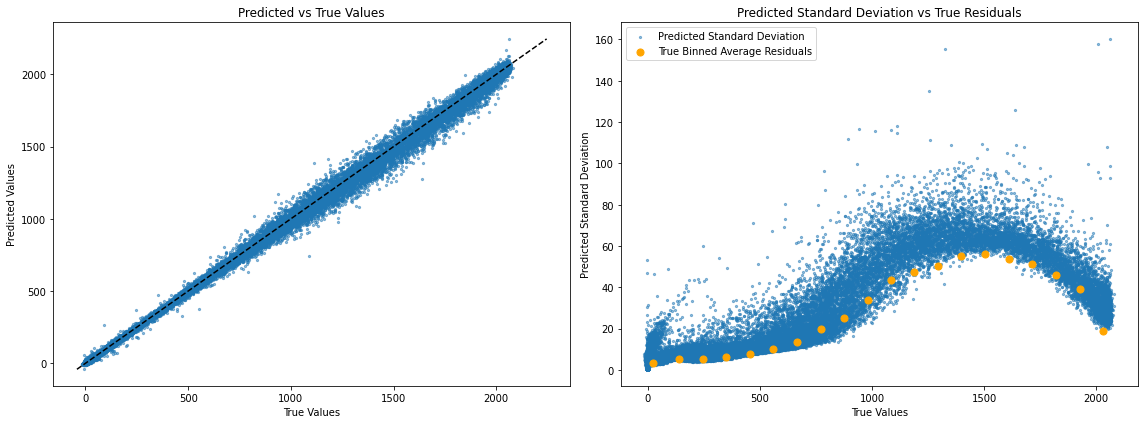

In [69]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

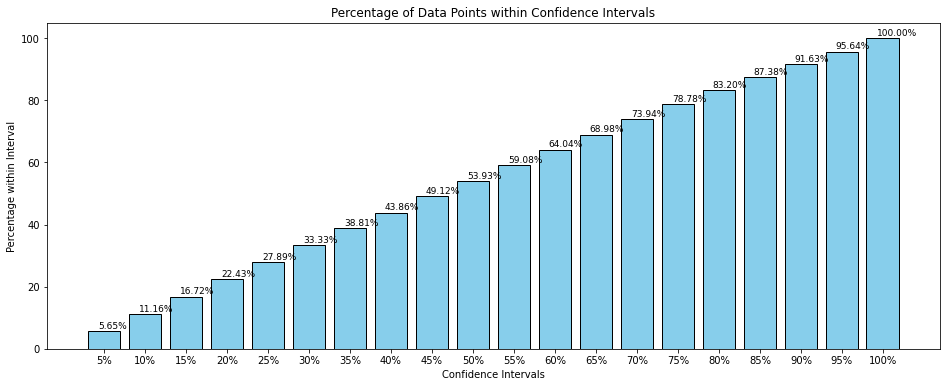

In [70]:
plot_confidence_interval_histogram(y_test_pred, y_test_stddevs, y_test, bins=20)

## Non-Bayesian
We create a non-Bayesian deep model for the mean and the standard deviation of a Gaussian. 

### Deep Neural Network with Gaussian Output (Separate Submodels)

Two identical and parallel networks process the input data independently to estimate the mean and variance parameters. These two sub-models employ three hidden layers with ReLU activation functions to capture non-linearity in the system with increasing levels of abstraction. The final layers of these sub-models are merged into a single output layer with two units, one for the predicted mean and one for the predicted variance). The loss is the negative log-likelihood of the Normal parametrized by these sub-models. This means, that, although the two sub-models extract independent non-linear features, they are trained simultaneously to minimize a common loss. 

In [394]:
def create_model_mlp_gaussian_separate(X_train):
    inputs = Input(shape=(X_train.shape[1],))
    mean_h1 = Dense(80, activation="relu")(inputs)
    variance_h1 = Dense(80, activation="relu")(inputs)
    
    mean_h2 = Dense(50, activation="relu")(mean_h1)
    variance_h2 = Dense(50, activation="relu")(variance_h1)
    
    mean_h3 = Dense(20, activation="relu")(mean_h2)
    variance_h3 = Dense(20, activation="relu")(variance_h2)
    
    mean_out = Dense(20, activation="relu")(mean_h3)
    variance_out = Dense(20, activation="relu")(variance_h3)
    
    params = Dense(2)(Concatenate()([mean_out, variance_out]))
    
    dist = tfp.layers.DistributionLambda(normal_softplus)(params) 

    model_mlp_gaussian = Model(inputs=inputs, outputs=dist)
    model_mlp_gaussian.compile(Adam(learning_rate=0.001), loss=NLL)

    return model_mlp_gaussian

model_mlp_gaussian_separate = create_model_mlp_gaussian_separate(X_train)

In [281]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_mlp_gaussian_separate.keras",
                                                 save_weights_only=True,
                                                 verbose=0)
history = train_model(model_mlp_gaussian_separate,
                      X_train, y_train,
                      patience=15, epochs=100, batch_size=32,
                      cp_callback=cp_callback)

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_51 (InputLayer)       [(None, 35)]                 0         []                            
                                                                                                  
 dense_487 (Dense)           (None, 80)                   2880      ['input_51[0][0]']            
                                                                                                  
 dense_488 (Dense)           (None, 80)                   2880      ['input_51[0][0]']            
                                                                                                  
 dense_489 (Dense)           (None, 50)                   4050      ['dense_487[0][0]']           
                                                                                           

In [396]:
model_mlp_gaussian_separate.load_weights("saved_models/model_mlp_gaussian_separate.keras")

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'saved_models/model_mlp_gaussian_separate.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [283]:
model_mlp_gaussian_separate.evaluate(X_test, y_test)

1184/1184 [==============================] - 2s 1ms/step - loss: 3.8322


3.8322105407714844

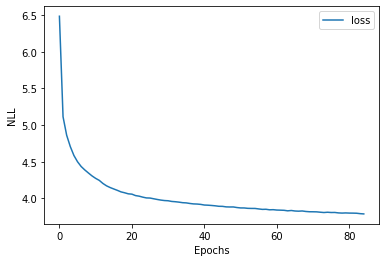

In [284]:
plt.plot(history.history['loss'][1:])
plt.legend(['loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show()

In [392]:
y_train_pred = np.array(model_mlp_gaussian_separate(X_train).mean()).ravel()
y_test_pred = np.array(model_mlp_gaussian_separate(X_test).mean()).ravel()

y_train_stddevs = np.array(model_mlp_gaussian_separate(X_train).stddev()).ravel()
y_test_stddevs = np.array(model_mlp_gaussian_separate(X_test).stddev()).ravel()

evaluate_and_print_metrics(results, "Non-Bayesian MLP with Gaussian Output (Separate Sub-models)",
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

NameError: name 'model_mlp_gaussian_separate' is not defined

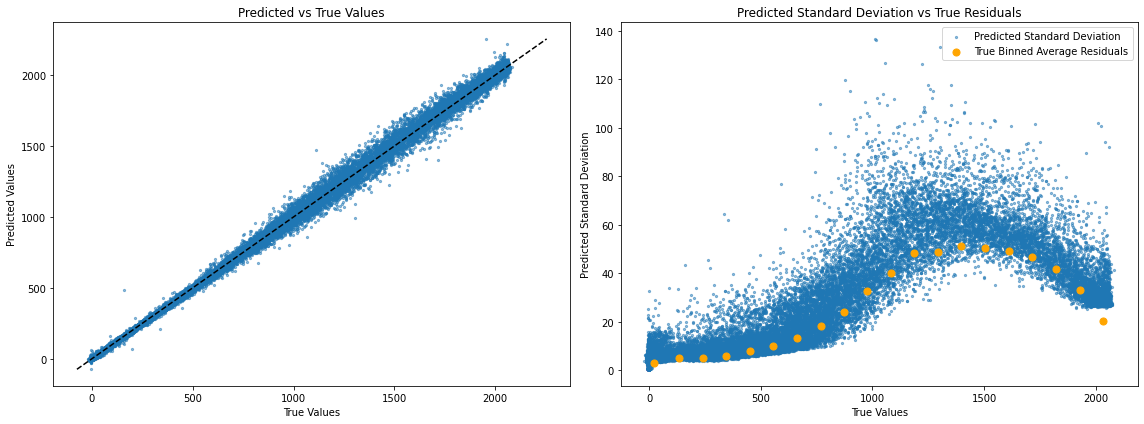

In [286]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

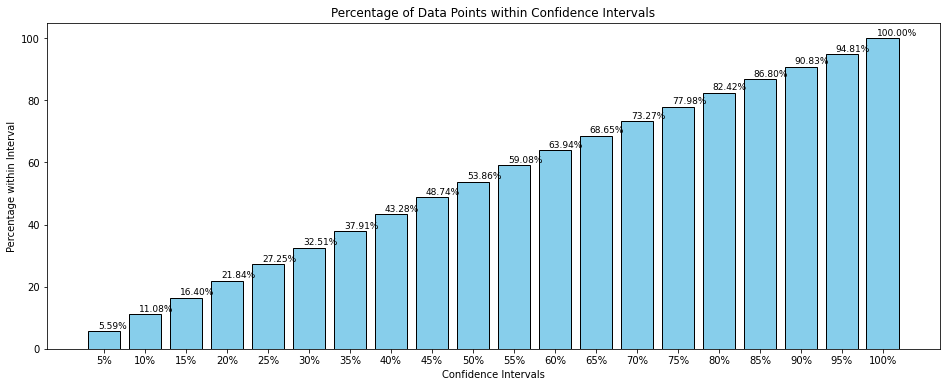

In [287]:
plot_confidence_interval_histogram(y_test_pred, y_test_stddevs, y_test, bins=20)

### Deep Neural Network with Gaussian Output (Joint Submodels)

A shared deep feature extractor sub-model is followed by two shallow sub-models with a single hidden layer and a single-unit output layer respectively. The first shared sub-model extract non-linear features from the input space, and the separate models estimate mean and variance respectively using non-linear combinations of the features extracted by the shared sub-model. The two single-unit outputs of the mean and variance sub-models are concatenated to represent the parameters of a univariate Normal.

In [300]:
def create_model_mlp_gaussian_joint(X_train):
    inputs = Input(shape=(X_train.shape[1],))
    
    hidden1 = Dense(100, activation="relu")(inputs)
    hidden2 = Dense(80, activation="relu")(hidden1)
    hidden3 = Dense(40, activation="relu")(hidden2)
    
    mean_h1 = Dense(20, activation="relu")(hidden3)
    mean_out = Dense(1)(mean_h1)
    
    variance_h1 = Dense(20, activation="relu")(hidden3)
    variance_out = Dense(1)(variance_h1)
    
    params = Dense(2)(Concatenate()([mean_out, variance_out]))

    
    dist = tfp.layers.DistributionLambda(normal_softplus)(params) 

    model_mlp_gaussian = Model(inputs=inputs, outputs=dist)
    model_mlp_gaussian.compile(Adam(learning_rate=0.001), loss=NLL)

    return model_mlp_gaussian

model_mlp_gaussian_joint = create_model_mlp_gaussian_joint(X_train)

In [301]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_mlp_gaussian_joint.keras",
                                                 save_weights_only=True,
                                                 verbose=0)
history = train_model(model_mlp_gaussian_joint,
                      X_train, y_train,
                      patience=15, epochs=100, batch_size=32,
                      cp_callback=cp_callback)

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_55 (InputLayer)       [(None, 35)]                 0         []                            
                                                                                                  
 dense_520 (Dense)           (None, 100)                  3600      ['input_55[0][0]']            
                                                                                                  
 dense_521 (Dense)           (None, 80)                   8080      ['dense_520[0][0]']           
                                                                                                  
 dense_522 (Dense)           (None, 40)                   3240      ['dense_521[0][0]']           
                                                                                           

In [397]:
model_mlp_gaussian_joint.load_weights("saved_models/model_mlp_gaussian_joint.keras")

In [398]:
model_mlp_gaussian_joint.evaluate(X_test, y_test)

1184/1184 [==============================] - 2s 1ms/step - loss: 3.7210


3.7210333347320557

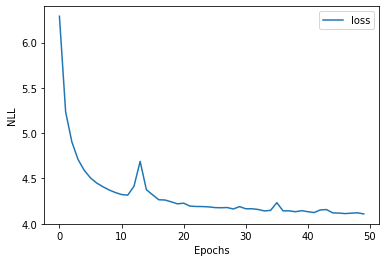

In [399]:
plt.plot(history.history['loss'][1:])
plt.legend(['loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show()

In [400]:
y_train_pred = np.array(model_mlp_gaussian_joint(X_train).mean()).ravel()
y_test_pred = np.array(model_mlp_gaussian_joint(X_test).mean()).ravel()

y_train_stddevs = np.array(model_mlp_gaussian_joint(X_train).stddev()).ravel()
y_test_stddevs = np.array(model_mlp_gaussian_joint(X_test).stddev()).ravel()

evaluate_and_print_metrics(results, "Non-Bayesian MLP with Gaussian Output (Joint Sub-models)",
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

Train RMSE: 26.315
Test RMSE: 26.641
Train MAE: 14.442
Test MAE: 14.575
Percentage of Train Data Points within 99.00% CI: 98.79%
Percentage of Test Data Points within 99.00% CI: 98.74%


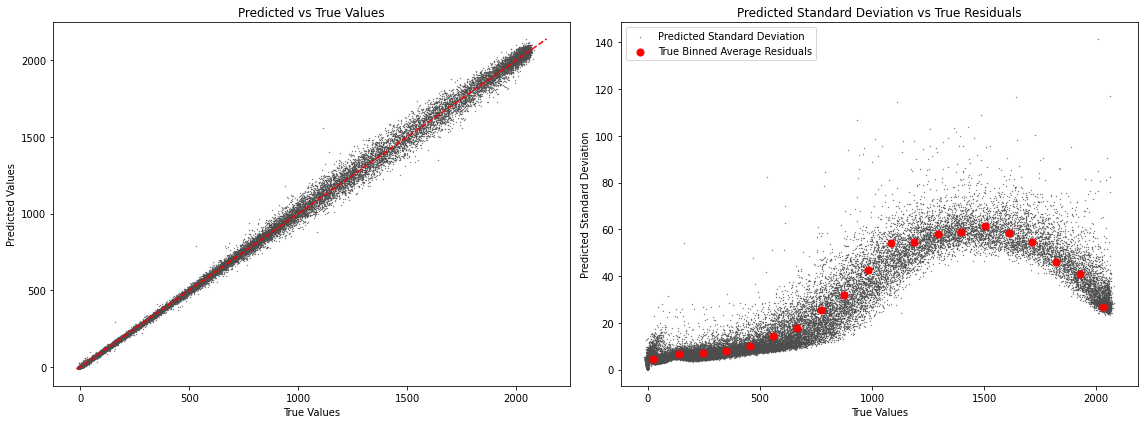

In [409]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

In [ ]:
plot_confidence_interval_histogram(y_test_pred, y_test_stddevs, y_test, bins=20)

By comparing the two architecture it is clear that a shared set of features decreases the model's out-of-sample error. Therefore, the proposed model in the study is the latter. 

Below are presented a set of model that have been tested as potential coompetitors to the finalized model above. They have been presented here as they represent more complicated ways of leveraging deep learning as a tool for normal behaviour modelling of wind turbines power curve. However, the increased complexity of the model did not who improvements in performance, therefore the simpler and more robust model presented above was chosen as th ebest candidate.

## Additional Models

### CNN with Gaussian Output

In light of a study conducted by et al. [2], we propose the use of a 1-D CNN to be used as an extractor of spatial features within out feature space. While this model is purely exploratory, we expect this not to excel, because of the almost non-existent spatial dependecy among features. In simpler terms, because CNNs capture spatial features, they are extremely dependent in the order of the features. In our case, the ordering of the features as little predictive significance, so the use of a convolution over the feature space of the input is not really empirically justified.

[2] Xiang, L., Wang, P., Yang, X., Hu, A., & Su, H. (2021). Fault de-
tection of wind turbine based on SCADA data analysis using CNN
and LSTM with an attention mechanism. Measurement, 175, 109094.
https://doi.org/10.1016/j.measurement.2021.109094

In [311]:
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [312]:
def create_model_cnn_gaussian(X_train):
    inputs = Input(shape=(X_train_cnn.shape[1], 1))
    conv1d_layer = Conv1D(filters=64, kernel_size=5, activation='relu')(inputs)
    maxpooling_layer = MaxPooling1D(pool_size=2)(conv1d_layer)
    flatten_layer = Flatten()(maxpooling_layer)
    hidden1 = Dense(20, activation="relu")(flatten_layer)
    hidden2 = Dense(50, activation="relu")(hidden1)
    hidden3 = Dense(20, activation="relu")(hidden2)
    params = Dense(2)(hidden3)
    dist = tfp.layers.DistributionLambda(normal_softplus)(params) 

    model_cnn_gaussian = Model(inputs=inputs, outputs=dist)
    model_cnn_gaussian.compile(Adam(learning_rate=0.01), loss=NLL)
    
    return model_cnn_gaussian

model_cnn_gaussian = create_model_cnn_gaussian(X_train_cnn)

In [313]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_cnn_gaussian.keras",
                                                 save_weights_only=True,
                                                 verbose=0)
history = train_model(model_cnn_gaussian,
                      X_train_cnn, y_train,
                      patience=15, epochs=100, batch_size=32,
                      cp_callback=cp_callback)

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_57 (InputLayer)       [(None, 35, 1)]           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 31, 64)            384       
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 15, 64)            0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 960)               0         
                                                                 
 dense_533 (Dense)           (None, 20)                19220     
                                                                 
 dense_534 (Dense)           (None, 50)                1050      
                                                          

In [314]:
model_cnn_gaussian.evaluate(X_test_cnn, y_test)

1184/1184 [==============================] - 3s 2ms/step - loss: 4.0826


4.082601070404053

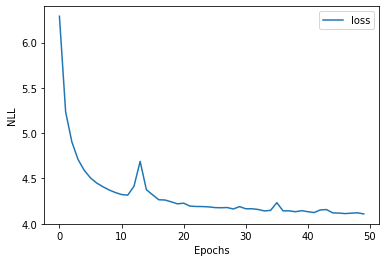

In [315]:
plt.plot(history.history['loss'][1:])
plt.legend(['loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show()

In [316]:
y_train_pred = np.array(model_cnn_gaussian(X_train_cnn).mean()).ravel()
y_test_pred = np.array(model_cnn_gaussian(X_test_cnn).mean()).ravel()

y_train_stddevs = np.array(model_cnn_gaussian(X_train_cnn).stddev()).ravel()
y_test_stddevs = np.array(model_cnn_gaussian(X_test_cnn).stddev()).ravel()

evaluate_and_print_metrics(results, "Non-Bayesian CNN with Gaussian Output",
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

Train RMSE: 31.472
Test RMSE: 32.287
Train MAE: 18.173
Test MAE: 18.449
Percentage of Train Data Points within 99.00% CI: 98.91%
Percentage of Test Data Points within 99.00% CI: 98.83%


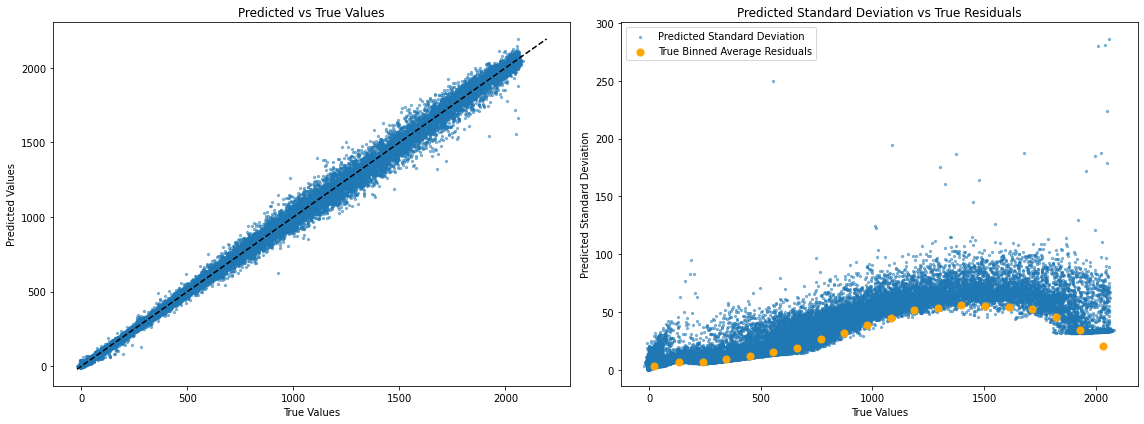

In [317]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

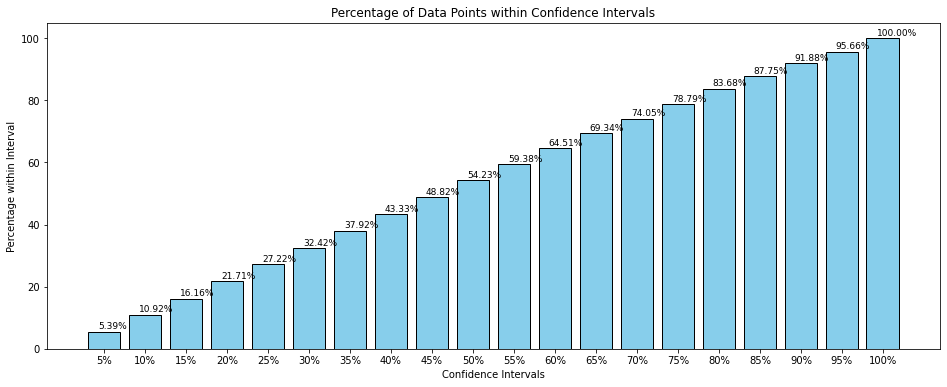

In [318]:
plot_confidence_interval_histogram(y_test_pred, y_test_stddevs, y_test, bins=20)

Clearly, the model is underperforming as compared to the MLP model with Normal output. This is probably the case because the features extracted by the Convolution layer have little significance. 

### Modelling Multiple Turbines: a Multivariate Experiment

We present below an experiment consisting of multi-turbine modelling. The reasoning motivating this research comes from studying and modelling the correlation between different turbines and investigating whether this can improve the predictive performance of the multivariate model. Below are presented deep networks with multivariate outputs for the 6 turbines. The output is a multivariate Gaussian of which we model the mean vector and lower triangular matrix of its Cholesky decomposition. In this case, the negative log likelihood is:

$$
\text{NLL}(\mu, \Sigma) = \sum_{i=1}^{n} -\frac{1}{2} \left[ d \cdot \log(2\pi) + \log\left(|(\Sigma(\mathbf{x}_i))|\right) + (\mathbf{y}_i - \boldsymbol{\mu(\mathbf{x}_i)})^T (\Sigma(\mathbf{x}_i))^{-1} (\mathbf{y}_i - \boldsymbol{\mu(\mathbf{x}_i)}) \right]
$$

In [416]:
def flatten_dataframe(df, features, output_feature, date_col):
    df['turbine_id'] = df['turbine']
    df = df.pivot(index=date_col, columns='turbine_id', values=features + [output_feature])
    df.columns = ['_'.join(map(str, col)).strip() for col in df.columns.values]
    return df

In [425]:
def train_multivariate_model(model, X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, patience=10):
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    model.build(X_train.shape)
    model.summary()

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=[early_stopping]
    )

    return history

In [420]:
# Specify the number of turbines to consider:
turbine_ids = [1, 2, 3, 4, 5, 6]
df_multivariate = flatten_dataframe(df_full[df_full['turbine'].isin(turbine_ids)], features, output_feature, DATETIME_COL)
df_multivariate.dropna(inplace=True)

In [421]:
df_multivariate.head()

Wind.speed.me_1  Wind.speed.me_2  Wind.speed.me_3  \
Date.time                                                                
2017-09-25 00:00:00         5.171129         4.757817         4.175850   
2017-09-25 00:10:00         5.090679         4.150517         4.813357   
2017-09-25 00:20:00         5.193162         4.944641         4.449074   
2017-09-25 00:30:00         4.995740         5.542314         3.575596   
2017-09-25 00:40:00         5.111104         5.335591         4.376520   

                     Wind.speed.me_4  Wind.speed.me_5  Wind.speed.me_6  \
Date.time                                                                
2017-09-25 00:00:00         4.738792         4.758976         4.289168   
2017-09-25 00:10:00         4.977407         5.053728         4.628090   
2017-09-25 00:20:00         5.095903         4.834767         4.549418   
2017-09-25 00:30:00         4.835490         4.909376         4.255482   
2017-09-25 00:40:00         4.976042         4.800600         4.402867   

                     Wind.speed.sd_1  Wind.speed.sd_2  Wind.speed.sd_3  \
Date.time                                                                
2017-09-25 00:00:00         0.390980         0.372854         0.743623   
2017-09-25 00:10:00         0.436131         0.481464         0.531176   
2017-09-25 00:20:00         0.305424         0.624760         0.573716   
2017-09-25 00:30:00         0.258361         0.436264         0.536631   
2017-09-25 00:40:00         0.296016         0.385295         0.902530   

                     Wind.speed.sd_4  Wind.speed.sd_5  Wind.speed.sd_6  \
Date.time                                                                
2017-09-25 00:00:00         0.430659         0.470051         0.310066   
2017-09-25 00:10:00         0.283841         0.455439         0.441148   
2017-09-25 00:20:00         0.404364         0.438846         0.497882   
2017-09-25 00:30:00         0.299969         0.403833         0.432935   
2017-09-25 00:40:00         0.291973         0.485835         0.385300   

                     Wind.speed.min_1  Wind.speed.min_2  Wind.speed.min_3  \
Date.time                                                                   
2017-09-25 00:00:00          4.240140          4.072932          3.108902   
2017-09-25 00:10:00          4.303428          3.237551          3.791599   
2017-09-25 00:20:00          4.739578          3.796388          3.076056   
2017-09-25 00:30:00          4.488607          4.738413          2.526803   
2017-09-25 00:40:00          4.674517          4.606429          3.033590   

                     Wind.speed.min_4  Wind.speed.min_5  Wind.speed.min_6  \
Date.time                                                                   
2017-09-25 00:00:00          4.021239          3.839334          3.719075   
2017-09-25 00:10:00          4.610759          4.297034          4.070392   
2017-09-25 00:20:00          4.493885          3.727230          3.312805   
2017-09-25 00:30:00          4.406585          3.910666          3.526326   
2017-09-25 00:40:00          4.271038          4.098299          3.900779   

                     Wind.speed.max_1  Wind.speed.max_2  Wind.speed.max_3  \
Date.time                                                                   
2017-09-25 00:00:00          5.912565          5.788143          5.526302   
2017-09-25 00:10:00          5.930200          4.728431          5.550539   
2017-09-25 00:20:00          5.894996          6.286856          5.410614   
2017-09-25 00:30:00          5.601314          6.424064          4.927535   
2017-09-25 00:40:00          5.677069          6.162595          5.830315   

                     Wind.speed.max_4  Wind.speed.max_5  Wind.speed.max_6  \
Date.time                                                                   
2017-09-25 00:00:00          5.713630          5.655419          4.900722   
2017-09-25 00:10:00          5.693741          5.879260          5.641960   
2017-09-25 00:20:

In [422]:
output_feature_columns = [c for c in df_multivariate.columns if c.startswith(output_feature)]
feature_columns = list(set(df_multivariate.columns).difference(output_feature_columns))

X_train_mult, X_test_mult, y_train_mult, y_test_mult, scaler_x_mult = load_dataset_train_test_split(df_multivariate, feature_columns, output_feature_columns)
y_train_mult = np.array(y_train_mult)
y_test_mult = np.array(y_test_mult)

In [423]:
print(X_train_mult.shape, y_train_mult.shape)

(73060, 210) (73060, 6)


In [424]:
# Number of turbines considered in the prediction
d = y_train_mult.shape[-1]
print("Number of turbines considered in the prediction: ", d)

Number of turbines considered in the prediction:  6


#### Diagonal Covariance Matrix

In this case, we investigate whether we can construct a model which is able to predict all means and variances simultaneously. In this simpler case we do not model covariances between turbines. 

In [482]:
def create_model_multivariate_gaussian_only_diagonal(d, input_size):
    inputs = Input(shape=input_size)
    
    outs = []

    for i in range(d):
        
        h_means1 = Dense(50, activation='relu')(inputs)
        h_cov1 = Dense(50, activation='relu')(inputs)
    
        h_means2 = Dense(30, activation='relu')(h_means1)
        h_cov2 = Dense(30, activation='relu')(h_cov1)
    
        h_means3 = Dense(20, activation='relu')(h_means2)
        h_cov3 = Dense(20, activation='relu')(h_cov2)
        
        out = Dense(2)(Concatenate()([h_means3, h_cov3]))
        outs.append(out)

    concatenated_outputs = Concatenate()(outs)
    
    # Define the distribution layer
    distribution_layer = tfp.layers.DistributionLambda(
        lambda t: multivariate_diagonal_normal_softplus(t[:, 0::2], t[:, 1::2], d)
    )
    
    model = Model(inputs=inputs, outputs=distribution_layer(concatenated_outputs),
                  name="multivariate_gaussian_with_covariance")
    
    model.compile(Adam(learning_rate=0.01),
                  loss=NLL)
   
    return model

In [483]:
model_multivariate_gaussian_only_diagonal = create_model_multivariate_gaussian_only_diagonal(d, (X_train_mult.shape[1],))
history = train_multivariate_model(model_multivariate_gaussian_only_diagonal, X_train_mult, y_train_mult, epochs=100, patience=10)

Model: "multivariate_gaussian_with_covariance"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_64 (InputLayer)       [(None, 210)]                0         []                            
                                                                                                  
 dense_754 (Dense)           (None, 50)                   10550     ['input_64[0][0]']            
                                                                                                  
 dense_755 (Dense)           (None, 50)                   10550     ['input_64[0][0]']            
                                                                                                  
 dense_761 (Dense)           (None, 50)                   10550     ['input_64[0][0]']            
                                                              

 concatenate_125 (Concatena  (None, 40)                   0         ['dense_772[0][0]',           
 te)                                                                 'dense_773[0][0]']           
                                                                                                  
 concatenate_126 (Concatena  (None, 40)                   0         ['dense_779[0][0]',           
 te)                                                                 'dense_780[0][0]']           
                                                                                                  
 concatenate_127 (Concatena  (None, 40)                   0         ['dense_786[0][0]',           
 te)                                                                 'dense_787[0][0]']           
                                                                                                  
 concatenate_128 (Concatena  (None, 40)                   0         ['dense_793[0][0]',           
 te)      

KeyboardInterrupt: 

In [484]:
model_multivariate_gaussian_only_diagonal.evaluate(X_test_mult, y_test_mult)

571/571 [==============================] - 2s 4ms/step - loss: 26.4097


26.409709930419922

In [485]:
y_train_mult_pred = np.array(model_multivariate_gaussian_only_diagonal(X_train_mult).mean())
y_test_mult_pred = np.array(model_multivariate_gaussian_only_diagonal(X_test_mult).mean())

y_train_mult_stddevs = np.array(model_multivariate_gaussian_only_diagonal(X_train_mult).stddev())
y_test_mult_stddevs = np.array(model_multivariate_gaussian_only_diagonal(X_test_mult).stddev())

y_train_mult_covs = np.array(model_multivariate_gaussian_only_diagonal(X_train_mult).covariance())
y_test_mult_covs = np.array(model_multivariate_gaussian_only_diagonal(X_test_mult).covariance())

evaluate_and_print_metrics(results, "Non-Bayesian Multivariate (Only Diagonal)",
                           y_train_mult.ravel(), y_test_mult.ravel(),
                           y_train_mult_pred.ravel(), y_test_mult_pred.ravel(),
                           y_train_mult_stddevs.ravel(), y_test_mult_stddevs.ravel(),
                           CONFIDENCE_INTERVAL)

Train RMSE: 35.570
Test RMSE: 36.981
Train MAE: 22.208
Test MAE: 23.040
Percentage of Train Data Points within 99.00% CI: 98.81%
Percentage of Test Data Points within 99.00% CI: 98.29%


In [490]:
for i in range(y_test_mult_pred.shape[1]):
    err = mean_squared_error(y_test_mult[:, i], y_test_mult_pred[:, i])
    print(f"Turbine #{i+1} - RMSE: {sqrt(err)}")

turbine #1 - RMSE: 37.014474397326396
turbine #2 - RMSE: 33.519361491324865
turbine #3 - RMSE: 35.83622662741971
turbine #4 - RMSE: 36.07027376620294
turbine #5 - RMSE: 40.83503464629457
turbine #6 - RMSE: 38.20130437030518


Turbine #1:


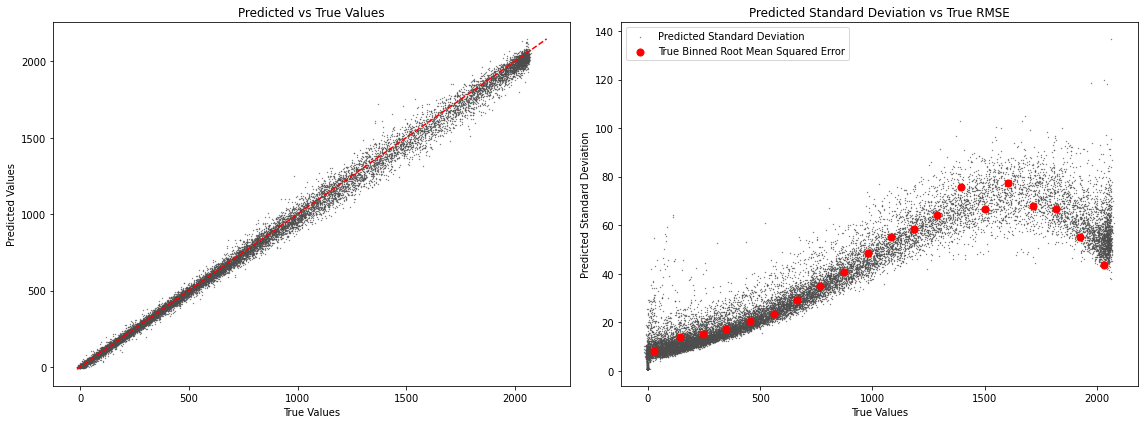

Turbine #2:


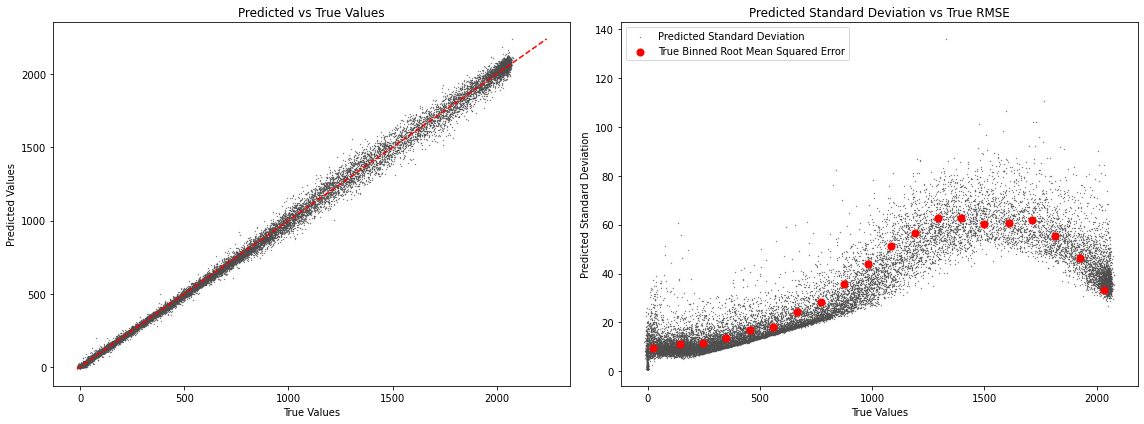

Turbine #3:


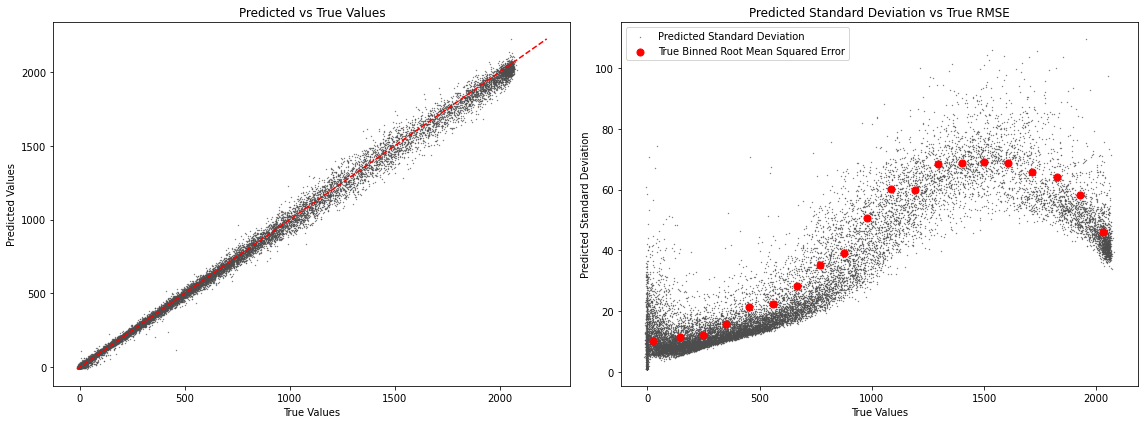

Turbine #4:


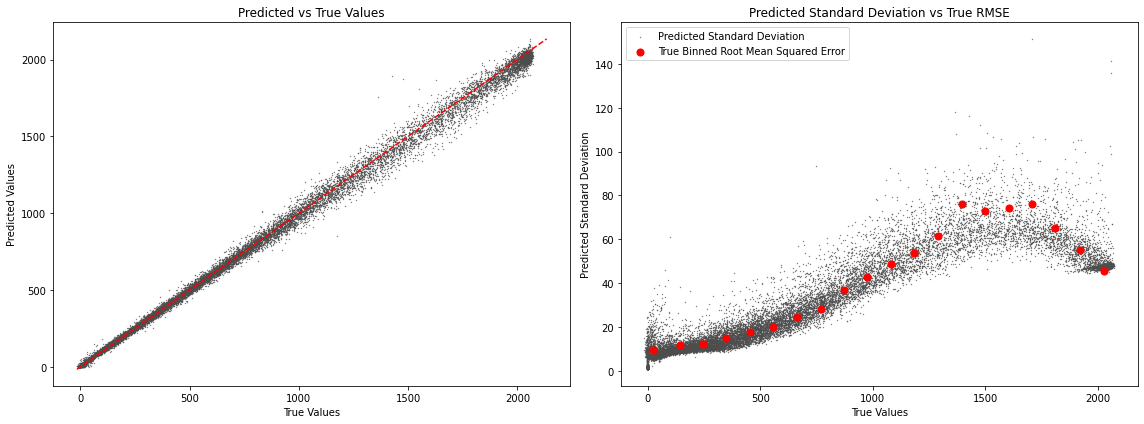

Turbine #5:


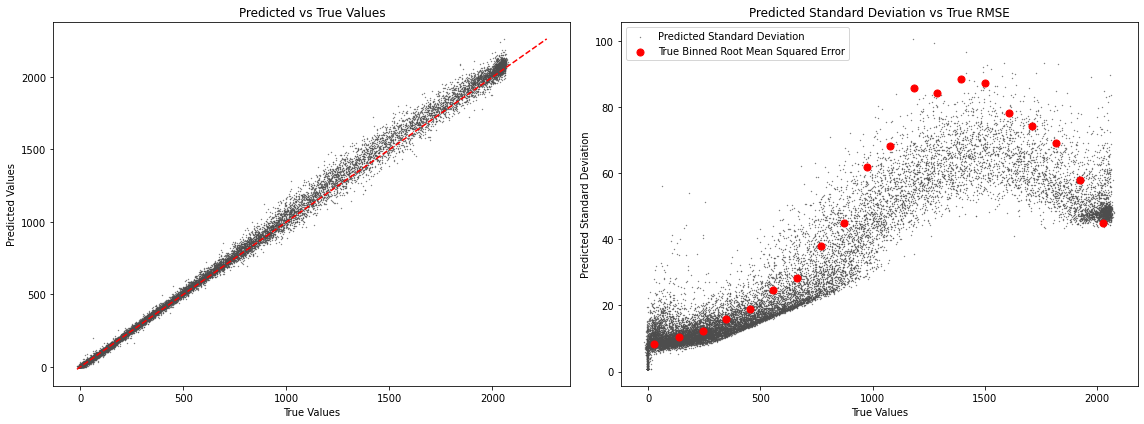

Turbine #6:


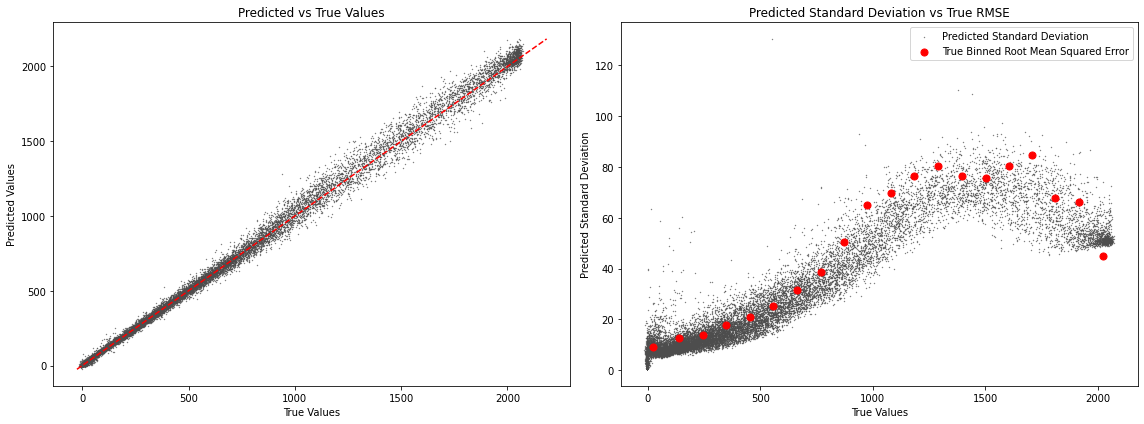

In [495]:
for i in range(y_test_mult_pred.shape[1]):
    print(f"Turbine #{i+1}:") 
    plot_means_variances(y_test_mult[:, i], y_test_mult_pred[:, i], y_test_mult_stddevs[:, i])

In [ ]:
for i in range(y_test_mult_pred.shape[1]):
    print(f"Turbine #{i+1}:")
    plot_confidence_interval_histogram(y_test_mult_pred[:, i], y_test_mult_stddevs[:, i], y_test_mult[:, i], bins=20)

#### Lower Triangular Cholesky Decomposed Covariance Matrix

In the model presented below we model the full covariance matrix of a gaussian distribution. In the world of real numbers, covariance matrices are symmetric and positive-definite. To enforce this we only parametrize a lower triangular matrix as part the Cholesky decomposition of the final full covariance matrix. Therefore, for $d$ turbines, we need $d$ output units for the predicted mean vector and $d(d-1)/2$ for the predicted covariance. So $d(d+1)/2$ in total.

In [496]:
def create_model_multivariate_gaussian_with_covariance(d, input_size):
    inputs = Input(shape=input_size)
    
    means_final_layers = []
    covs_final_layers = []

    for i in range(d):
        n_features = inputs.shape[1]//d
        
        h_means1 = Dense(50, activation='relu')(inputs)
        h_cov1 = Dense(50, activation='relu')(inputs)
    
        h_means2 = Dense(30, activation='relu')(h_means1)
        h_cov2 = Dense(30, activation='relu')(h_cov1)
    
        h_means3 = Dense(20, activation='relu')(h_means2)
        h_cov3 = Dense(20, activation='relu')(h_cov2)
        
        means_final_layers.append(h_means3)
        covs_final_layers.append(h_cov3)
        
    concatenated_h_means1 = Concatenate()(means_final_layers)
    concatenated_h_covs1 = Concatenate()(covs_final_layers)
    
    concatenated_h_means2 = Dense(20, activation='relu')(concatenated_h_means1)
    concatenated_h_covs2 = Dense(20, activation='relu')(concatenated_h_covs1)
    
    out_mean = Dense(d, activation='linear')(concatenated_h_means2)
    out_cov = Dense(tfp.layers.MultivariateNormalTriL.params_size(d) - d)(concatenated_h_covs2)
    
    # Concatenate mean and lower triangular part of the covariance matrix
    concatenated_outputs = Concatenate()([out_mean, out_cov])
    
    # Define the distribution layer
    distribution_layer = tfp.layers.DistributionLambda(
        lambda t: multivariate_covariance_normal_softplus(t[:, :d], t[:, d:], d)
    )
    
    model = Model(inputs=inputs, outputs=distribution_layer(concatenated_outputs),
                  name="multivariate_gaussian_with_covariance")
    
    model.compile(Adam(learning_rate=0.01),
                  loss=NLL)
   
    return model

In [497]:
model_multivariate_gaussian_with_covariance = create_model_multivariate_gaussian_with_covariance(d, (X_train_mult.shape[1],))
history = train_multivariate_model(model_multivariate_gaussian_with_covariance, X_train_mult, y_train_mult, epochs=100, patience=10)

(None, 210)
(None, 210)
(None, 210)
(None, 210)
(None, 210)
(None, 210)
(None, 6)
(None, 21)
Model: "multivariate_gaussian_with_covariance"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_67 (InputLayer)       [(None, 210)]                0         []                            
                                                                                                  
 dense_876 (Dense)           (None, 50)                   10550     ['input_67[0][0]']            
                                                                                                  
 dense_882 (Dense)           (None, 50)                   10550     ['input_67[0][0]']            
                                                                                                  
 dense_888 (Dense)           (None, 50)                   10550     

                                                                     'dense_910[0][0]']           
                                                                                                  
 concatenate_137 (Concatena  (None, 120)                  0         ['dense_881[0][0]',           
 te)                                                                 'dense_887[0][0]',           
                                                                     'dense_893[0][0]',           
                                                                     'dense_899[0][0]',           
                                                                     'dense_905[0][0]',           
                                                                     'dense_911[0][0]']           
                                                                                                  
 dense_912 (Dense)           (None, 20)                   2420      ['concatenate_136[0][0]']     
          

In [498]:
model_multivariate_gaussian_with_covariance.evaluate(X_test_mult, y_test_mult)

571/571 [==============================] - 4s 7ms/step - loss: 32.2194


32.21939468383789

In [499]:
y_train_mult_pred = np.array(model_multivariate_gaussian_with_covariance(X_train_mult).mean())
y_test_mult_pred = np.array(model_multivariate_gaussian_with_covariance(X_test_mult).mean())

y_train_mult_stddevs = np.array(model_multivariate_gaussian_with_covariance(X_train_mult).stddev())
y_test_mult_stddevs = np.array(model_multivariate_gaussian_with_covariance(X_test_mult).stddev())

y_train_mult_covs = np.array(model_multivariate_gaussian_with_covariance(X_train_mult).covariance())
y_test_mult_covs = np.array(model_multivariate_gaussian_with_covariance(X_test_mult).covariance())

evaluate_and_print_metrics(results, "Non-Bayesian Multivariate (Lower Triangular Covariance Matrix)",
                           y_train_mult.ravel(), y_test_mult.ravel(),
                           y_train_mult_pred.ravel(), y_test_mult_pred.ravel(),
                           y_train_mult_stddevs.ravel(), y_test_mult_stddevs.ravel(),
                           CONFIDENCE_INTERVAL)

Train RMSE: 71.337
Test RMSE: 71.267
Train MAE: 48.714
Test MAE: 48.684
Percentage of Train Data Points within 99.00% CI: 98.87%
Percentage of Test Data Points within 99.00% CI: 98.82%


In [476]:
for i in range(y_test_mult_pred.shape[1]):
    err = mean_squared_error(y_test_mult[:, i], y_test_mult_pred[:, i])
    print("turbine #", i+1, "- RMSE:", sqrt(err))

turbine # 1 - RMSE: 84.04970455202167
turbine # 2 - RMSE: 152.82445093977313
turbine # 3 - RMSE: 99.29008299092392
turbine # 4 - RMSE: 133.46010155975677
turbine # 5 - RMSE: 104.8147594494069
turbine # 6 - RMSE: 117.65304743783469


Turbine #1:


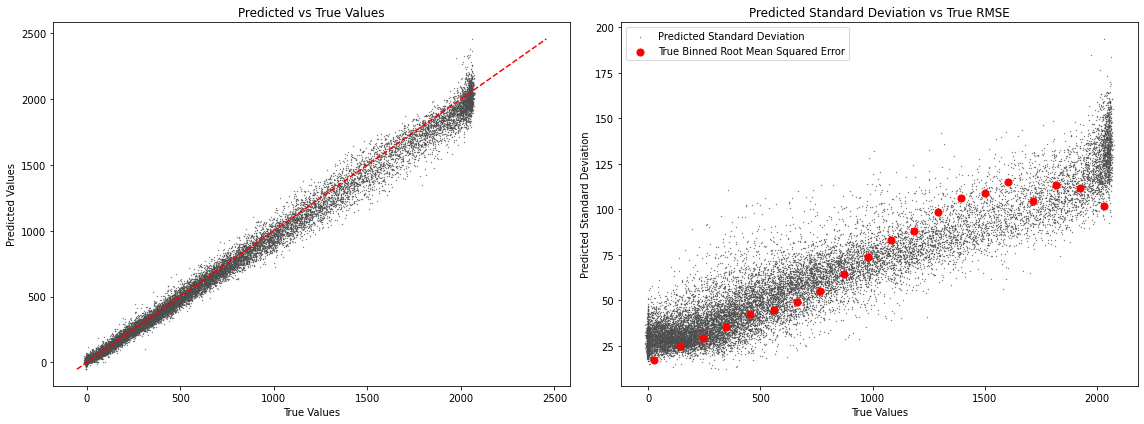

Turbine #2:


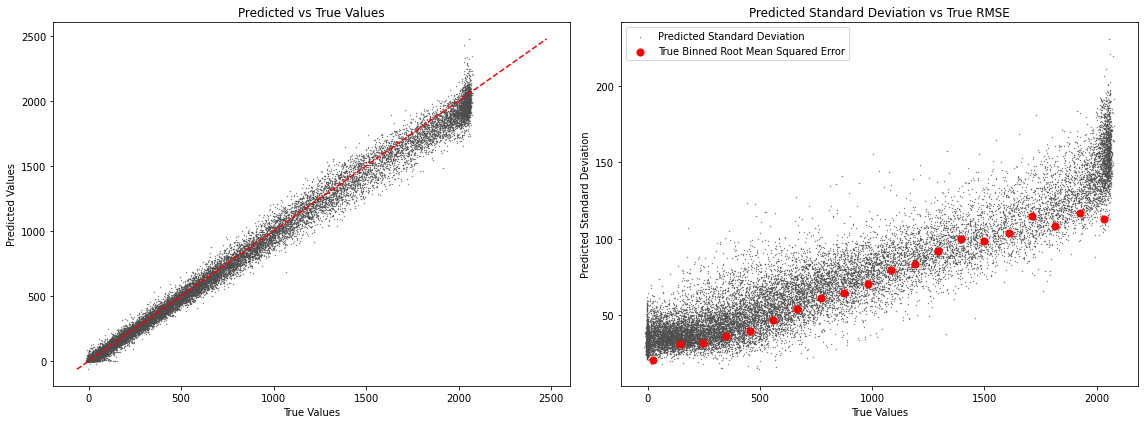

Turbine #3:


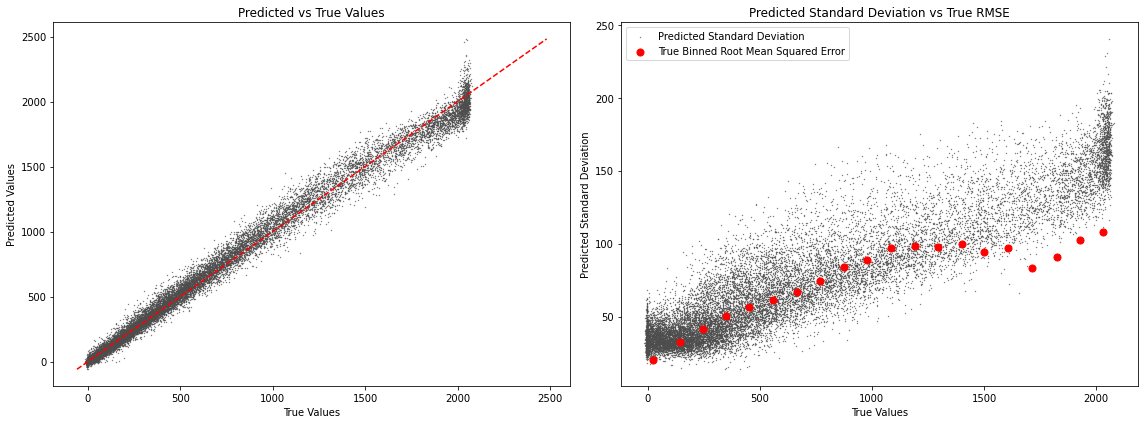

Turbine #4:


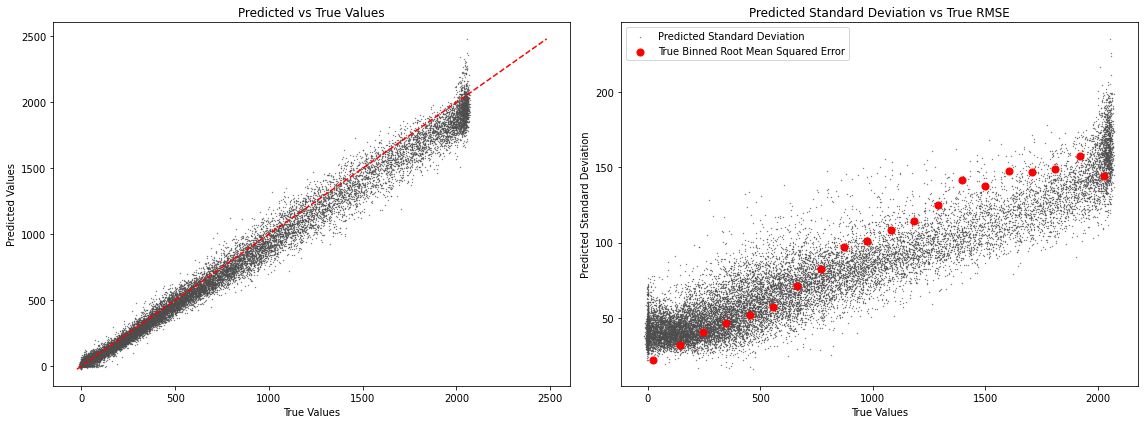

Turbine #5:


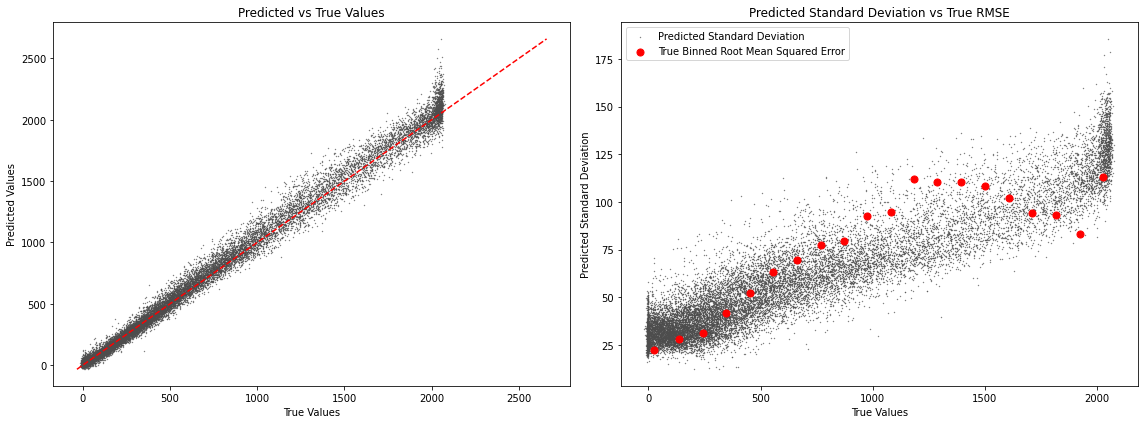

Turbine #6:


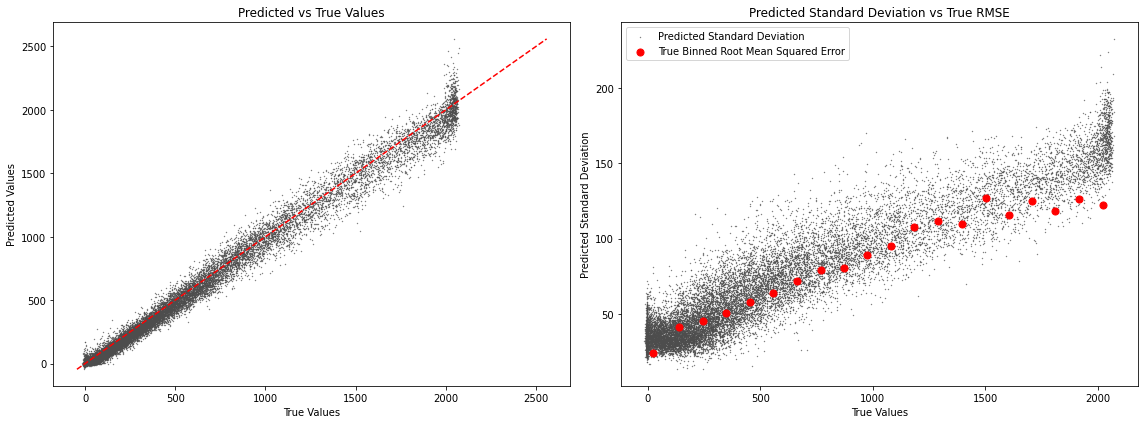

In [500]:
for i in range(y_test_mult_pred.shape[1]):
    print(f"Turbine #{i+1}:") 
    plot_means_variances(y_test_mult[:, i], y_test_mult_pred[:, i], y_test_mult_stddevs[:, i])

Turbine #1:


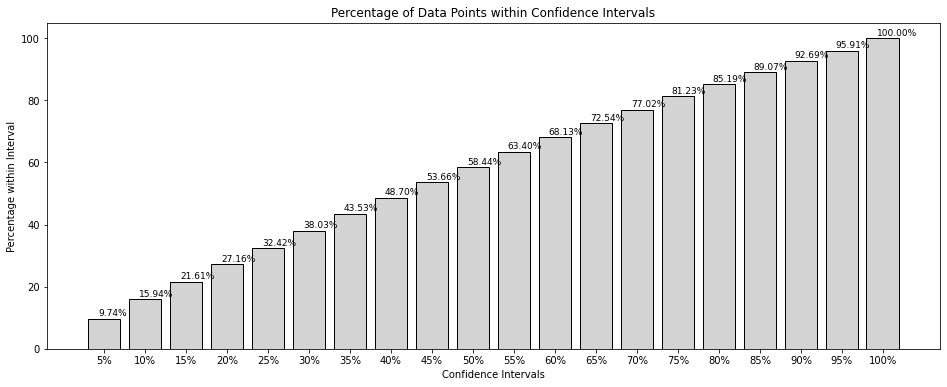

Turbine #2:


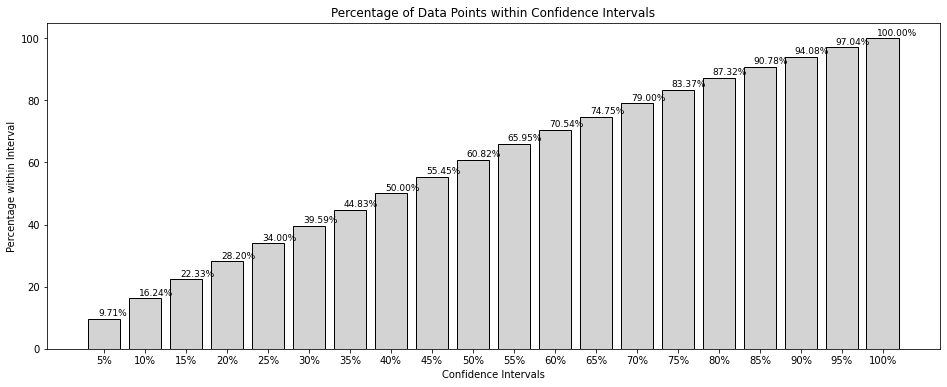

Turbine #3:


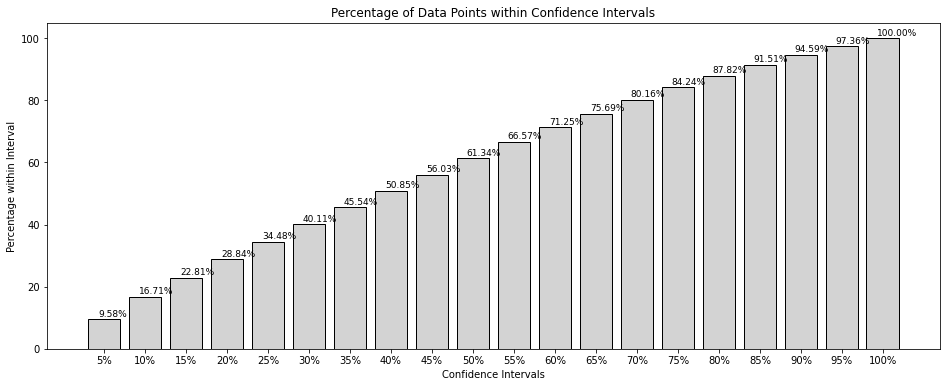

Turbine #4:


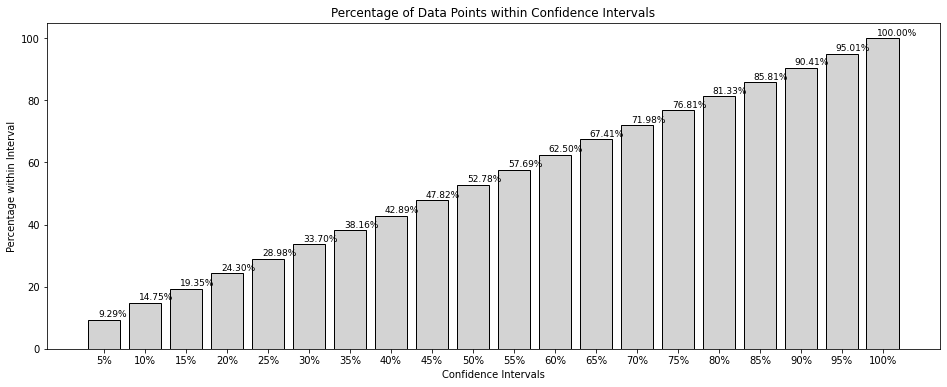

Turbine #5:


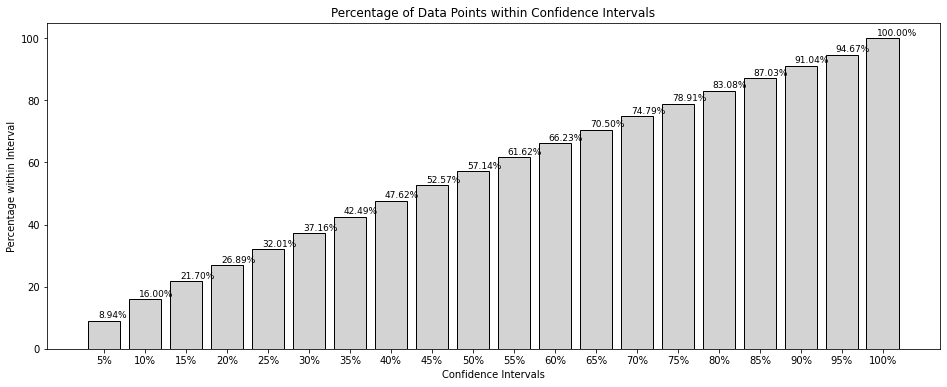

Turbine #6:


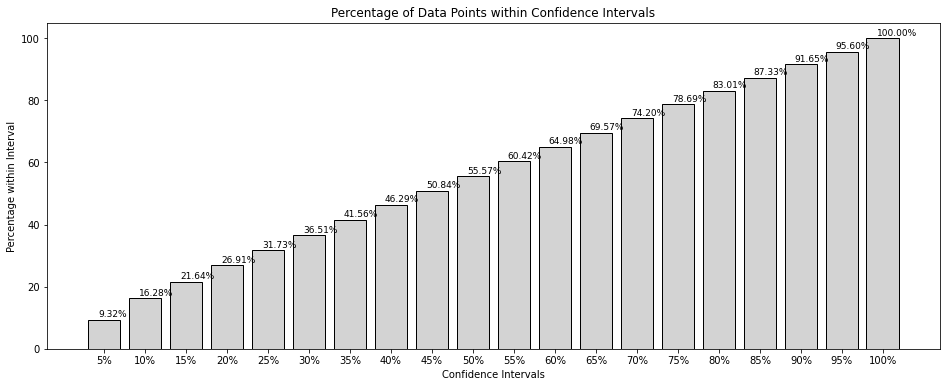

In [501]:
for i in range(y_test_mult_pred.shape[1]):
    print(f"Turbine #{i+1}:")
    plot_confidence_interval_histogram(y_test_mult_pred[:, i], y_test_mult_stddevs[:, i], y_test_mult[:, i], bins=20)

We notice that the multivariate models do not perform even close to their univariate counterparts. This could be related to the variances of different turbines being predicted a very close. Similarly, as we expect correlations between turbines to be close to 1, covariances also would have values very close to the variances. This leads to  

While we acknowledge that these multivariate models do not perform as accurately as its univariate counterparts, the exploration of this multivariate study leads to believe that, with larger data sets and greater computational resources, larger probabilistic networks could be trained to perform a probabilistic deep learning multivariate normal behaviour modelling of the power output of entire wind farms. This is something that, to the author's knowledge, has never been achieved before. In particular the limited data set of 73k data points for a very large number of tunable parameters, for example more than 150k in the network modelling covariance, does not allow to sufficiently reduce the predictive variance, quantified in the amount of variation of the target function when considering a different dataset, of the network given its large capacity. 